# **Prediccion Series Diarias**




Jhon Esteban Arredondo Parra - 1035443205

Gerson Gabriel Erira - 1085931900

## **Objetivo**
Implementar modelos de Machine learning y Deep Learning para las ventas de productos masivos en 217 municipios de 5 departamentos de Colombia, con el fin de buscar el mejor modelo que aporte a la identificación de posibles preferencias de compra, tendencias de consumo y con esto proyectar un comportamiento por subcategoría de producto.

In [ ]:
# pip install eralchemy #instalar libreria, si no esta disponible
#downgrade tensorflow tensorflow==2.15
# !pip install tensorflow==2.15

In [ ]:
#Cargar datos de Github
import io
import requests


#Manipulacion de datos
import pandas as pd
import numpy as np
import os
from collections import Counter
# from eralchemy import render_er
# from sqlalchemy import (MetaData, Table, Column, ForeignKey)


#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


# Gráficos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

##evitar warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Crear un DataFrame vacío para almacenar métricas
df_metricas = pd.DataFrame(columns=['Modelo', 'RMSE_train', 'R2_train', 'MAPE_train','RMSE_test', 'R2_test', 'MAPE_test'])

# Función para calcular métricas y almacenarlas en el DataFrame
def evaluar_modelo(nombre_modelo, modelo, X_train, y_train, X_test, y_test):
    predicciones_test = modelo.predict(X_test)
    predicciones_train = modelo.predict(X_train)

    global scaler_y
    predicciones_train = scaler_y.inverse_transform(predicciones_train.reshape(-1, 1))
    predicciones_test = scaler_y.inverse_transform(predicciones_test.reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # Calcular métricas test
    rmse_train = np.sqrt(mean_squared_error(y_train, predicciones_train))
    r2_train = r2_score(y_train, predicciones_train)
    mape_train = mean_absolute_percentage_error(y_train, predicciones_train)

    # Calcular métricas test
    rmse_test = np.sqrt(mean_squared_error(y_test, predicciones_test))
    r2_test = r2_score(y_test, predicciones_test)
    mape_test = mean_absolute_percentage_error(y_test, predicciones_test)

    # Agregar resultados al DataFrame
    global df_metricas
    df_metricas = pd.concat([df_metricas, pd.DataFrame({'Modelo': [nombre_modelo],
                                                        'RMSE_train': [rmse_train], 'R2_train': [r2_train], 'MAPE_train': [mape_train],
                                                        'RMSE_test': [rmse_test], 'R2_test': [r2_test], 'MAPE_test': [mape_test],
                                                        })], ignore_index=True)


# 1. Cargar Datos

In [ ]:
df_interpolado = pd.read_csv('datosPorDiaDepartamento_interpolado.csv')

In [ ]:
df_interpolado['FECHA'] = pd.to_datetime(df_interpolado['FECHA'])
#quitar ultimo trimestre
df_interpolado = df_interpolado[df_interpolado['FECHA'] < '2022-10-01']
df_interpolado['FECHA'].max()

Timestamp('2022-09-30 00:00:00')

# 2. Serie Interpolada

## 2.1. Analisis Exploratorio de Datos (EDA)

In [ ]:
df_interpolado.columns

Index(['FECHA', 'mes', 'dia_num', 'subcategory', 'Dia', 'Tipo Dia', 'Dpto',
       'CANTIDAD',
       'Cuarta medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Segunda medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de hom

### Variables Numericas

In [ ]:
fig = px.box(df_interpolado, y='CANTIDAD', hover_data=["subcategory"],
             title='Distribución de las Cantidades',
             color_discrete_sequence=px.colors.qualitative.Dark2_r)
fig.show()

In [ ]:
##para una mejor visualización, a continuacion acortamos las columnas con demasiados caracteres
new_column_names = {col: col.replace("en  la entidad territorial", "") for col in df_interpolado.columns}
df_interpolado.rename(columns=new_column_names, inplace=True)

In [ ]:
df_interpolado.select_dtypes(include=['float', 'int']).columns[3:]


Index(['Cuarta medida correctiva al Código Nacional de Policía más impuesta ',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta ',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta ',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta ',
       'Segunda medida correctiva al Código Nacional de Policía más impuesta ',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de homicidio intencional en hombres por cada 100.000 habitantes',
       'Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de hurto a personas por cada 100.000 habitantes',
       'Tasa de les

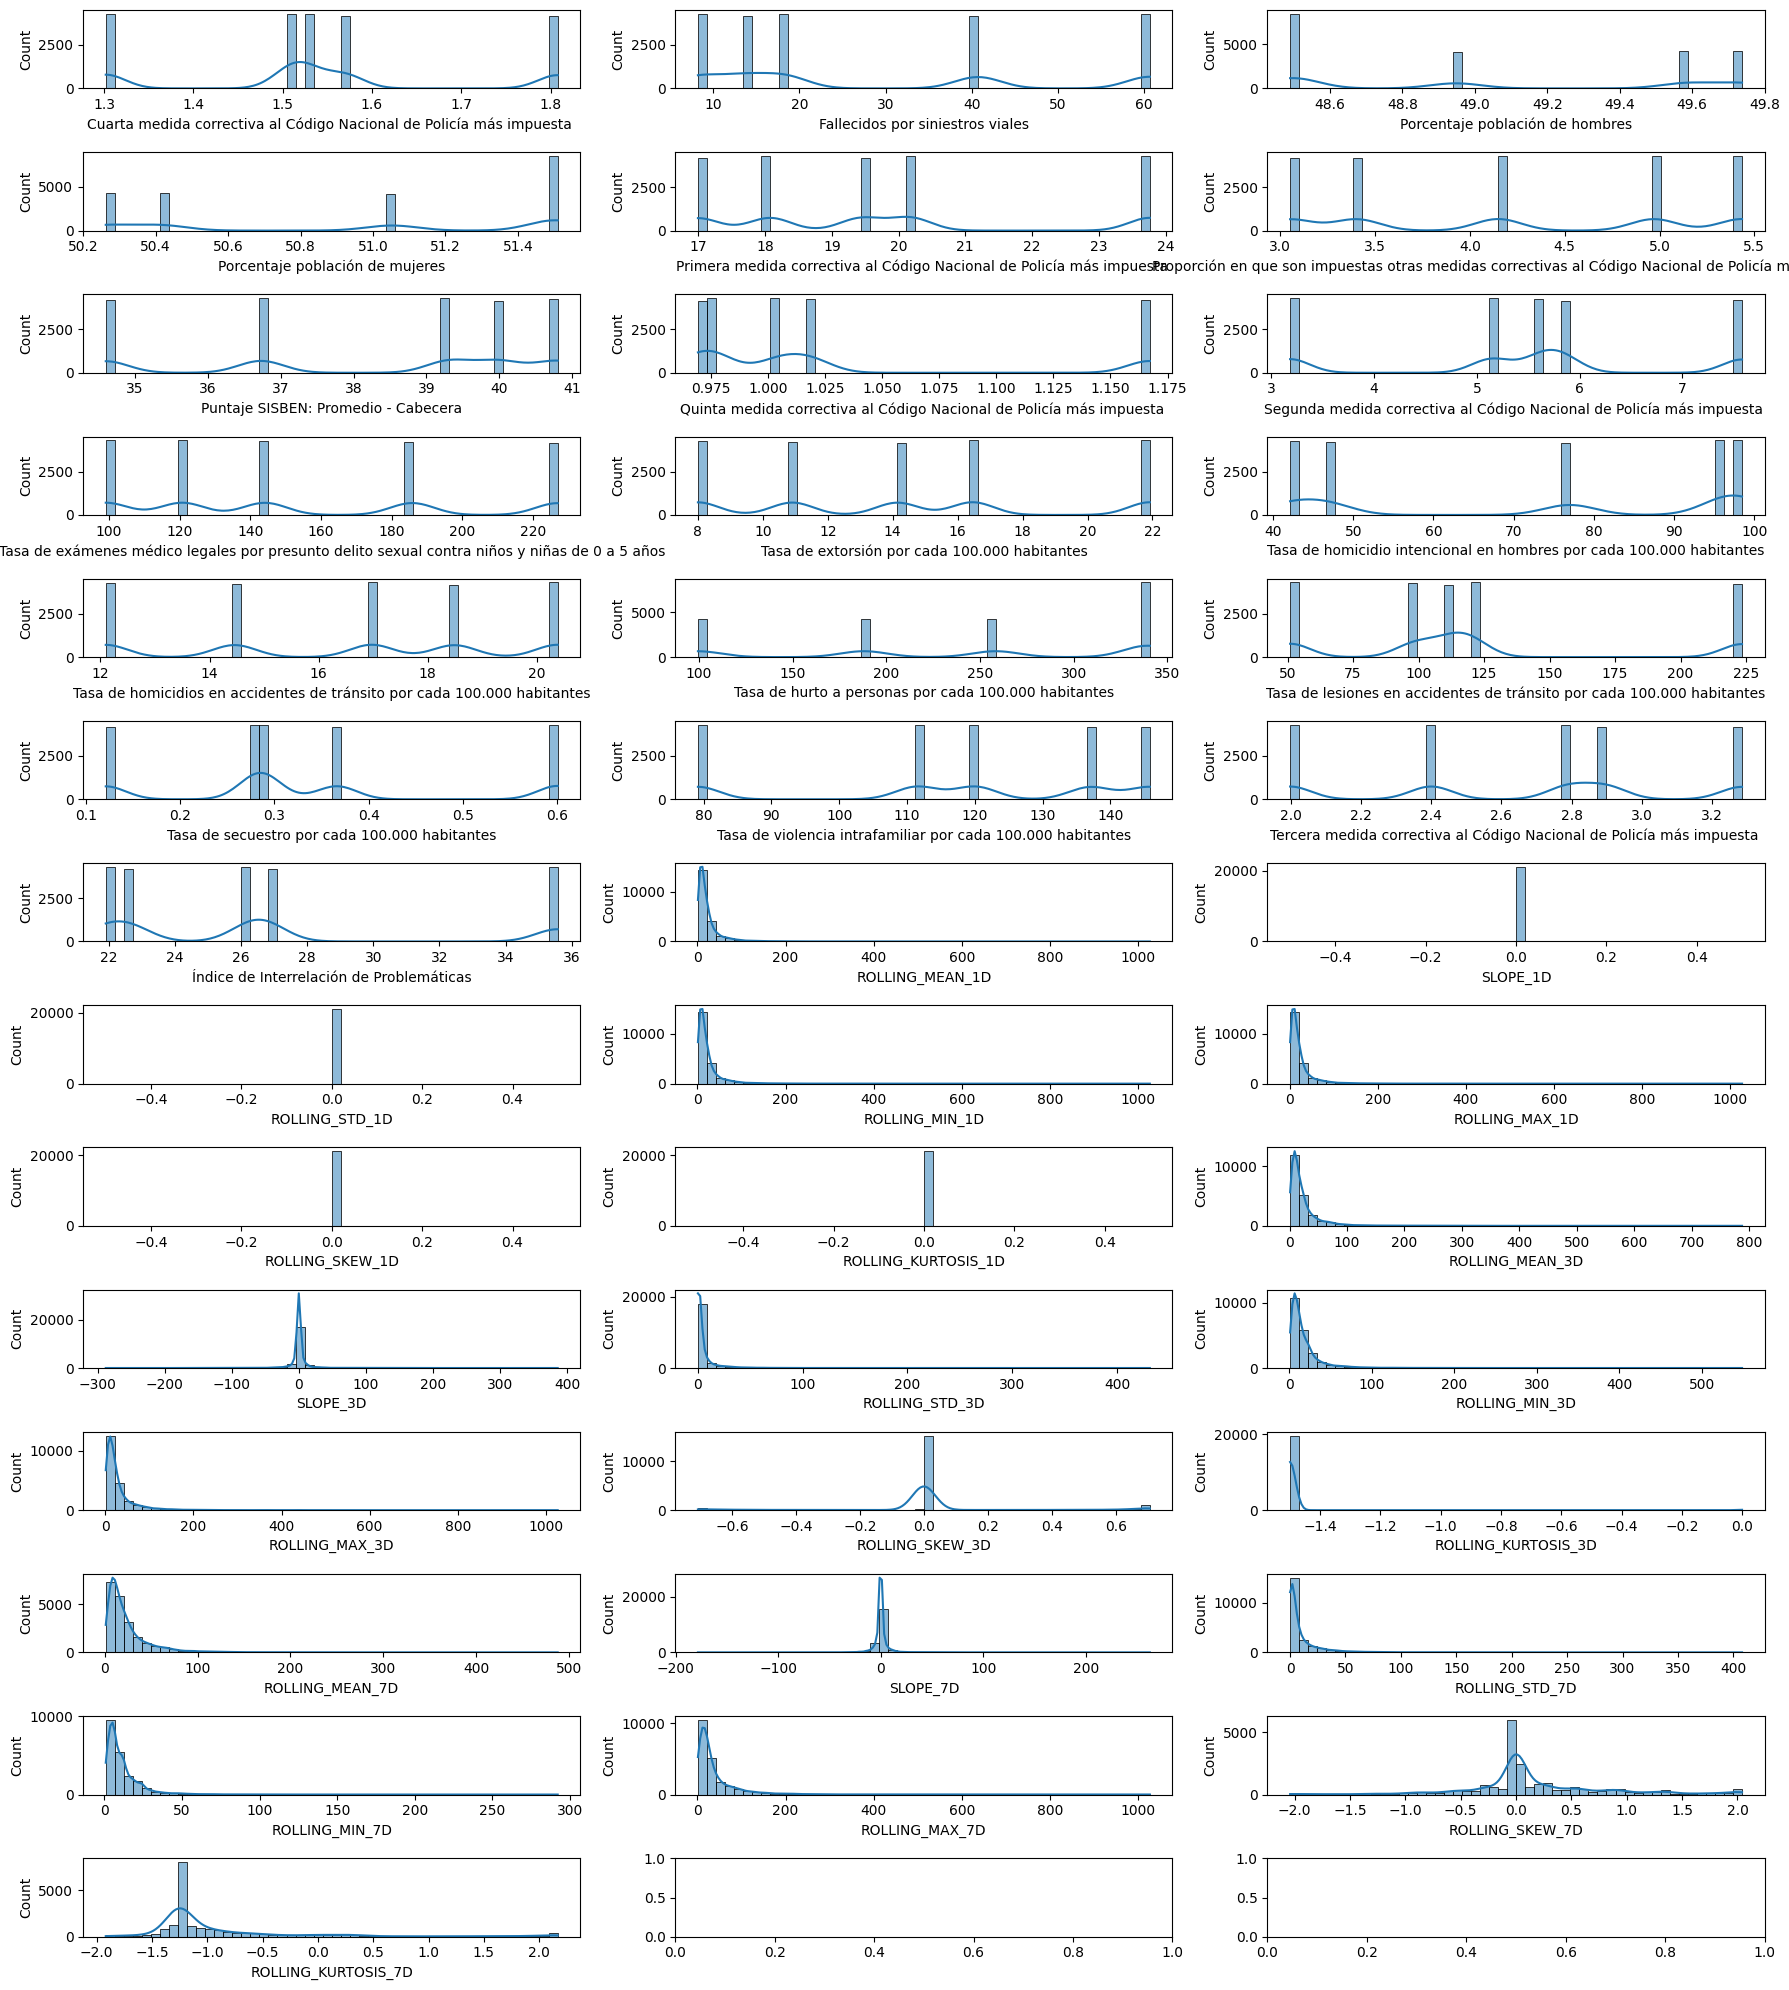

In [ ]:
##distribucion de variables cuantitativas
columns_to_plot = df_interpolado.select_dtypes(include=['float', 'int']).columns[3:]

# Crear un grid de gráficos
fig, axes = plt.subplots(14, 3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_interpolado[col], ax=axes[i], kde=True, bins=50)
    # axes[i].set_title(f'Distribución de {col}')

plt.tight_layout()
plt.show()


In [ ]:
#plot matriz de correlación
corr = df_interpolado.select_dtypes(include=['float', 'int']).corr()
corr.style.background_gradient(cmap='coolwarm')

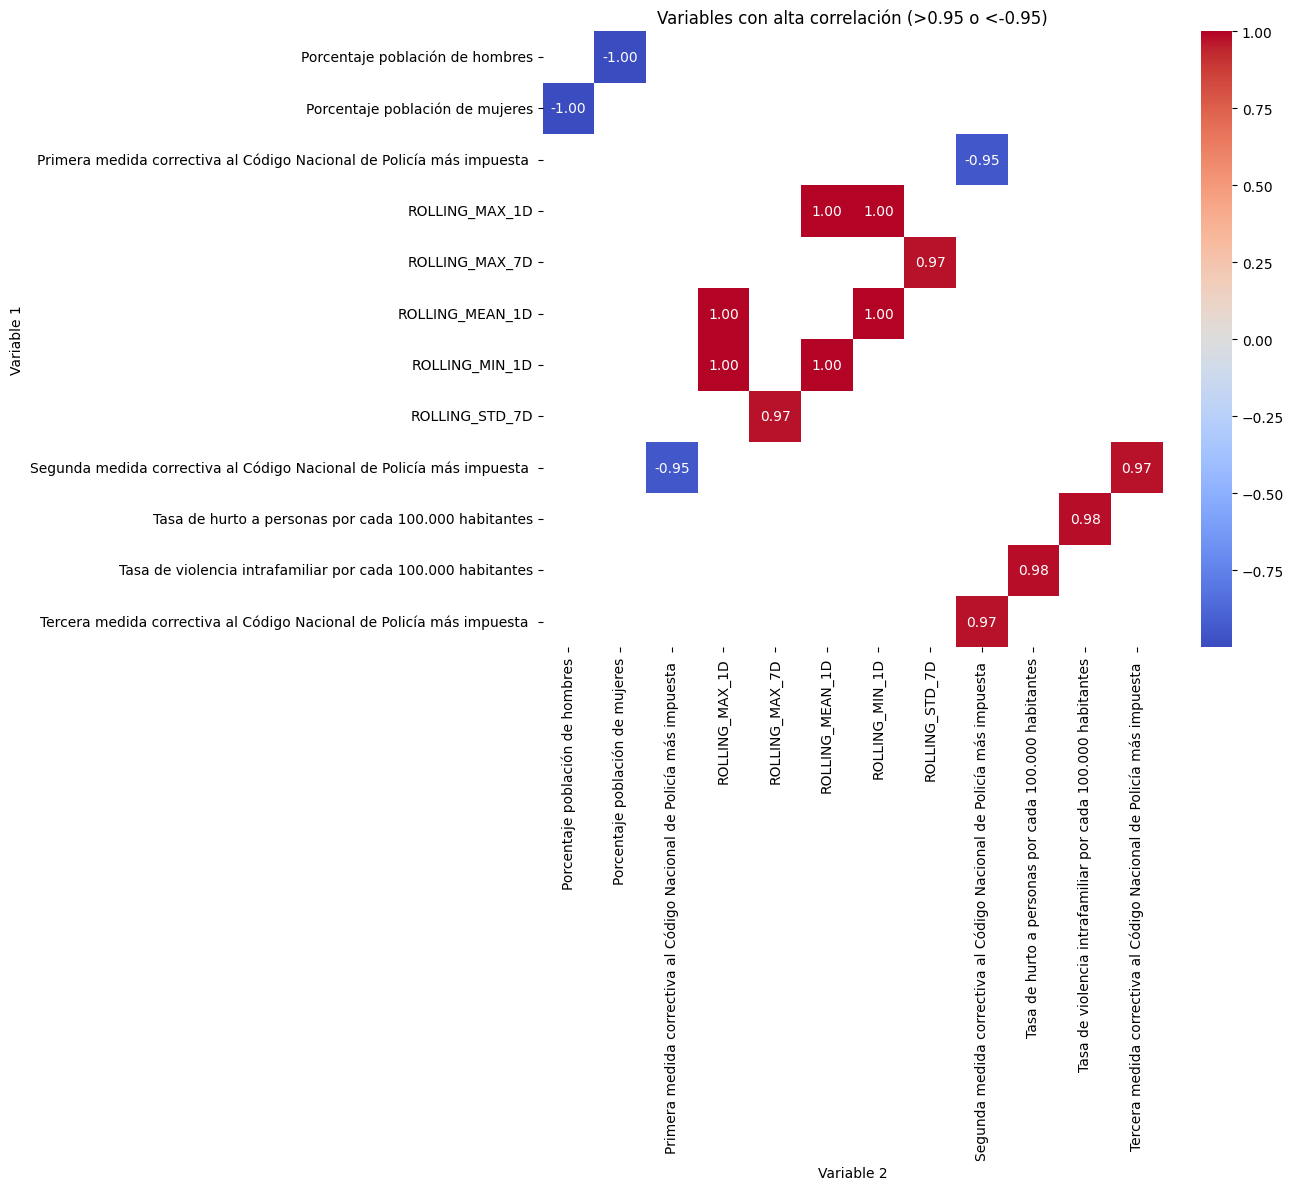

In [ ]:
# prompt: graficar las relaciones mayores a 0.95 o menores a -0.95, excluyendo las que son contra la misma variable

# Filtrar correlaciones mayores a 0.95 o menores a -0.95 y que no sean la diagonal principal
high_corr = corr[(corr > 0.95) | (corr < -0.95)]
high_corr = high_corr.stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlacion']

# Graficar las relaciones filtradas
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr.pivot(index='Variable 1', columns='Variable 2', values='Correlacion'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Variables con alta correlación (>0.95 o <-0.95)')
plt.show()


In [ ]:
##correlacion de pearson
corr = df_interpolado.select_dtypes(include=['float', 'int']).corr()
corr["CANTIDAD"].sort_values(ascending=False)

CANTIDAD                                                                                                 1.000000
ROLLING_MIN_1D                                                                                           0.700724
ROLLING_MEAN_1D                                                                                          0.700724
ROLLING_MAX_1D                                                                                           0.700724
ROLLING_MEAN_3D                                                                                          0.658132
ROLLING_MIN_3D                                                                                           0.611717
ROLLING_MAX_3D                                                                                           0.587860
ROLLING_MEAN_7D                                                                                          0.565429
ROLLING_MAX_7D                                                                                           0.483522
ROLLING_STD_7D                                                                                           0.424073
ROLLING_MIN_7D                                                                                           0.389558
ROLLING_STD_3D                                                                                           0.372476
SLOPE_7D                                                                                                 0.360312
SLOPE_3D                                                                                                 0.269226
Primera medida correctiva al Código Nacional de Policía más impuesta                                     0.218649
Tasa de homicidio intencional en hombres por cada 100.000 habitantes                                     0.189591
Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta     0.186708
Tasa de extorsión por cada 100.000 habitantes                                                            0.167521
Índice de Interrelación de Problemáticas                                                                 0.158415
Tasa de secuestro por cada 100.000 habitantes                                                            0.127638
Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes                                 0.097222
ROLLING_SKEW_7D                                                                                          0.080891
Fallecidos por siniestros viales                                                                         0.079580
Porcentaje población de hombres                                                                          0.077934
ROLLING_KURTOSIS_7D                                                                                      0.063974
ROLLING_SKEW_3D                                                                                          0.024203
ROLLING_KURTOSIS_3D                                                                                      0.012905
dia_num                                                                                                 -0.010223
Puntaje SISBEN: Promedio - Cabecera                                                                     -0.014490
mes                                                                                                     -0.038017
Tasa de violencia intrafamiliar por cada 100.000 habitantes                                             -0.055301
Quinta medida correctiva al Código Nacional de Policía más impuesta                                     -0.068291
Porcentaje población de mujeres                                                                         -0.077938
Tasa de hurto a personas por cada 100.000 habitantes                                                    -0.089910
Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes                                  -0.141907
Segunda me

In [ ]:
##correlacion de spearman
corr = df_interpolado.select_dtypes(include=['float', 'int']).corr(method='spearman')
corr["CANTIDAD"].sort_values(ascending=False)

CANTIDAD                                                                                                 1.000000
ROLLING_MIN_1D                                                                                           0.869365
ROLLING_MEAN_1D                                                                                          0.869365
ROLLING_MAX_1D                                                                                           0.869365
ROLLING_MEAN_3D                                                                                          0.815370
ROLLING_MAX_3D                                                                                           0.803933
ROLLING_MIN_3D                                                                                           0.733628
ROLLING_MEAN_7D                                                                                          0.724556
ROLLING_MAX_7D                                                                                           0.694316
ROLLING_STD_3D                                                                                           0.533199
ROLLING_MIN_7D                                                                                           0.526858
ROLLING_STD_7D                                                                                           0.512992
SLOPE_7D                                                                                                 0.332817
SLOPE_3D                                                                                                 0.281690
Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta     0.215013
Primera medida correctiva al Código Nacional de Policía más impuesta                                     0.212560
Tasa de extorsión por cada 100.000 habitantes                                                            0.198393
Tasa de homicidio intencional en hombres por cada 100.000 habitantes                                     0.198393
Tasa de secuestro por cada 100.000 habitantes                                                            0.188331
Fallecidos por siniestros viales                                                                         0.157572
Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes                                 0.089174
ROLLING_KURTOSIS_7D                                                                                      0.087375
Índice de Interrelación de Problemáticas                                                                 0.070044
ROLLING_SKEW_7D                                                                                          0.051946
Porcentaje población de hombres                                                                          0.032006
ROLLING_KURTOSIS_3D                                                                                      0.023488
ROLLING_SKEW_3D                                                                                          0.018415
Quinta medida correctiva al Código Nacional de Policía más impuesta                                      0.006516
mes                                                                                                     -0.000834
dia_num                                                                                                 -0.027080
Porcentaje población de mujeres                                                                         -0.032006
Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes                                  -0.089232
Puntaje SISBEN: Promedio - Cabecera                                                                     -0.100346
Tasa de violencia intrafamiliar por cada 100.000 habitantes                                             -0.100589
Tasa de hurto a personas por cada 100.000 habitantes                                                    -0.134654
Tercera me

### Variables Categoricas

In [ ]:
df_interpolado.select_dtypes(include=['object']).describe()

subcategory      Dia Tipo Dia             Dpto
count        21204    21204    21204            21204
unique          16        7        4                5
top      Pasabocas  Viernes  Laboral  VALLE DEL CAUCA
freq          1351     6413    15601             4299

Inicialmente teniamos una lista de 3829 productos distintos, sin embargo, por su alta diversidad se utilizará para efectos del trabajo con la subcategoria asociada, las cuales son 16 clases distintas. Ya el dataset está agregado a nivel de subcategoria

Caso similar sucede con los municipios, donde son 217 pero se trabajara con el departamento al que pertenecen

Por ende, las columnas PRODUCTO, Subregion y Municipio no harán parte del dataset final que se usará para entrenar modelos de regresión

In [ ]:
df_interpolado["subcategory"].value_counts()

subcategory
Pasabocas                         1351
Frutas y Verduras                 1351
Despensa                          1344
Productos Congelados              1340
Dulces y postres                  1339
Cuidado Personal                  1339
Limpieza de cocina                1336
Panadería y Pastelería            1333
Lácteos, huevos y refrigerados    1332
Bebidas                           1327
Vinos y Licores                   1326
Utiles Escolares                  1321
Charcutería                       1317
Aseo de hogar                     1312
Belleza                           1273
Cuidado de ropa y calzado         1263
Name: count, dtype: int64

In [ ]:
df_interpolado.pivot_table(index="subcategory", columns="mes", values="CANTIDAD", aggfunc="sum")

mes                                       1            2            3  \
subcategory                                                             
Aseo de hogar                   2294.500000  1125.000000  1234.000000   
Bebidas                         1630.500000  1385.500000  3726.245455   
Belleza                         1595.500000  1447.000000  1984.750000   
Charcutería                     1623.043651  1531.500000  1051.000000   
Cuidado Personal                4254.904760  5432.000000  5268.500000   
Cuidado de ropa y calzado       2233.105606  4560.405606  4643.500000   
Despensa                        5905.800000  5301.228571  5438.600000   
Dulces y postres                8902.458945  4363.000000  8582.452053   
Frutas y Verduras               6125.000000  6164.000000  6622.000000   
Limpieza de cocina              8012.571429  4488.642857  5151.000000   
Lácteos, huevos y refrigerados  2459.000000  3643.000000  3856.500000   
Panadería y Pastelería          3481.738378  1225.500000  1143.000000   
Pasabocas                       5329.500000  3923.000000  4101.000000   
Productos Congelados            1383.200000  1914.535714  4638.900000   
Utiles Escolares                5804.480543  5606.038095  3860.142857   
Vinos y Licores                 3586.000000  3437.500000  1349.000000   

mes                                       4            5            6  \
subcategory                                                             
Aseo de hogar                   1488.500000  1401.000000  1888.500000   
Bebidas                         2967.928571  2977.000000  1867.000000   
Belleza                         1901.500000  1253.000000  2794.500000   
Charcutería                     1189.500000  1129.000000  1334.000000   
Cuidado Personal                4165.000000  3251.500000  4456.438095   
Cuidado de ropa y calzado       3871.361365  1193.500000  2394.500000   
Despensa                        3441.000000  4914.500000  3925.000000   
Dulces y postres                7899.068254  6368.544444  3299.257143   
Frutas y Verduras               6614.500000  6194.500000  5671.000000   
Limpieza de cocina              4473.000000  3892.500000  6878.500000   
Lácteos, huevos y refrigerados  4071.500000  4197.500000  3567.000000   
Panadería y Pastelería          1355.000000  1107.000000  1979.500000   
Pasabocas                       4487.500000  4852.000000  5079.500000   
Productos Congelados            1422.700000  1944.035714  2802.000000   
Utiles Escolares                2860.071429  2480.500000  3253.500000   
Vinos y Licores                 3874.500000  1619.500000  3106.500000   

mes                                       7            8            9  
subcategory                                                            
Aseo de hogar                   1423.000000  3107.134052  1466.129150  
Bebidas                         1868.500000  2708.000000  2085.862149  
Belleza                         1090.000000  1277.500000   991.735165  
Charcutería                      970.000000  2005.000000  1492.419737  
Cuidado Personal                3252.500000  4509.500000  2120.166667  
Cuidado de ropa y calzado       2298.000000  2114.000000   979.473754  
Despensa                        3608.000000  3477.200000  4399.059524  
Dulces y postres                3946.544444  4411.673016  5649.503175  
Frutas y Verduras               5325.000000  7925.000000  5571.500000  
Limpieza de cocina              7707.404762  7916.785714  3895.668287  
Lácteos, huevos y refrigerados  3375.500000  4288.149954  3179.939560  
Panadería y Pastelería          1314.000000  3225.485043   719.666236  
Pasabocas                       5107.666667  4470.833333  3898.153846  
Productos Congelados            2020.000000  3083.468750  1180.963415  
Utiles Escolares                2781.500000  5371.500000  1907.282680  
Vinos y Licores                 2684.000000  2066.000000  1997.682615

In [ ]:
df_interpolado.pivot_table(index="Dpto", columns="mes", values="CANTIDAD", aggfunc="sum")

mes                         1             2             3             4  \
Dpto                                                                      
ANTIOQUIA        23406.399206  16468.142857  20042.500000  15635.744444   
CALDAS           10605.846750   9522.628571   9742.000000   7176.928571   
QUINDÍO           8819.591942   6272.000000   8886.918719   6312.571429   
RISARALDA         6607.821762   9220.943702   9683.047619  11983.385175   
VALLE DEL CAUCA  15181.643651  14064.135714  14296.124026  14974.000000   

mes                         5             6             7             8  \
Dpto                                                                      
ANTIOQUIA        14226.544444  17535.771429  15971.949206  17481.292474   
CALDAS            7308.500000   8498.500000   7727.500000  12014.149954   
QUINDÍO           5789.000000   5916.000000   5018.666667   8172.458863   
RISARALDA         8260.500000   8159.000000   6377.000000   8707.500000   
VALLE DEL CAUCA  13191.035714  14187.423810  13676.500000  15581.828571   

mes                         9  
Dpto                           
ANTIOQUIA        14102.126984  
CALDAS            6142.308009  
QUINDÍO           2803.261068  
RISARALDA         6302.321192  
VALLE DEL CAUCA  12185.188705

In [ ]:
import plotly.express as px

# Crear el box plot usando Plotly
fig = px.box(df_interpolado,
             x='Dpto',
             y='CANTIDAD',
             color='Dpto',
             title='Distribución de la Subregión vs. Cantidades',
             color_discrete_sequence=px.colors.qualitative.Safe,
             hover_data=["subcategory", "mes"])


# Personalizar el gráfico
fig.update_layout(
    xaxis_title='dp_pruebas_rellenadoto',
    yaxis_title='CANTIDAD',
    title={
        'text': 'Distribución de la Subregión vs. Cantidades',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 14, 'family': 'Arial', 'color': 'black'},
    }
)

# Rotar las etiquetas del eje x
fig.update_xaxes(tickangle=90)

fig.show()


In [ ]:
# Crear el box plot usando Plotly
fig = px.box(df_interpolado,
             x='subcategory',
             y='CANTIDAD',
             color='subcategory',
             title='Distribución de la subcategoria vs. Cantidades',
             color_discrete_sequence=px.colors.qualitative.Bold,
             hover_data=["Dpto", "mes"])


# Personalizar el gráfico
fig.update_layout(
    xaxis_title='subcategory',
    yaxis_title='CANTIDAD',
    title={
        'text': 'Distribución de la subcategoria vs. Cantidades',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 14, 'family': 'Arial', 'color': 'black'},
    }
)

# Rotar las etiquetas del eje x
fig.update_xaxes(tickangle=90)

fig.show()

## 2.2. Datos de Prueba

In [ ]:
##para el modelo no requerimos de los campos FECHA, UNIDAD, municipio, departamento y total por las razones mencionadas a lo largo del analisis
df_interpolado = df_interpolado[['subcategory',
        'Dpto',
       'CANTIDAD',
       'ROLLING_MEAN_1D', 'ROLLING_MEAN_3D', 'ROLLING_MEAN_7D',
       'SLOPE_3D', 'SLOPE_7D',
       'ROLLING_STD_3D', 'ROLLING_STD_7D',
       'ROLLING_MIN_3D', 'ROLLING_MIN_7D',
       'ROLLING_MAX_3D', 'ROLLING_MAX_7D',
       'ROLLING_SKEW_3D',
         'ROLLING_SKEW_7D',
       'ROLLING_KURTOSIS_3D',
        #  'ROLLING_KURTOSIS_7D',
       'Cuarta medida correctiva al Código Nacional de Policía más impuesta ',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta ',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta ',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta ',
      #  'Segunda medida correctiva al Código Nacional de Policía más impuesta ',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de homicidio intencional en hombres por cada 100.000 habitantes',
       'Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de hurto a personas por cada 100.000 habitantes',
       'Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de secuestro por cada 100.000 habitantes',
       'Tasa de violencia intrafamiliar por cada 100.000 habitantes',
      #  'Tercera medida correctiva al Código Nacional de Policía más impuesta ',
       'Índice de Interrelación de Problemáticas',
        'FECHA' ##dejamos la FECHA para identificar la correcta separación en train and test. pero no será parte de los modelos.
         ]]

df_interpolado['FECHA'] = pd.to_datetime(df_interpolado['FECHA'])
df_interpolado = df_interpolado.sort_values(by="FECHA", ascending=True).reset_index(drop=True)

In [ ]:
df_interpolado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21204 entries, 0 to 21203
Data columns (total 35 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   subcategory                                                                                            21204 non-null  object        
 1   Dpto                                                                                                   21204 non-null  object        
 2   CANTIDAD                                                                                               21204 non-null  float64       
 3   ROLLING_MEAN_1D                                                                                        21124 non-null  float64       
 4   ROLLING_MEAN_3D                                     

In [ ]:
df_interpolado.shape

(21204, 35)

In [ ]:
# Porcentaje de filas para la primera parte (train y test)
percentage_first_part = 0.90

# Número de filas para la primera parte
n_rows_part1 = int(len(df_interpolado) * percentage_first_part)

##obtenemos la fecha de corte, donde se aproxima el 90% de nuestros datos
fecha_corte = df_interpolado.loc[n_rows_part1, 'FECHA']

# Dividir el DataFrame en dos partes, a partir de la fecha de corte
df_prep_rellenado = df_interpolado.loc[df_interpolado['FECHA']<=fecha_corte]
dp_pruebas_rellenado = df_interpolado.loc[df_interpolado['FECHA']>fecha_corte]

In [ ]:
df_prep_rellenado.FECHA.max(), dp_pruebas_rellenado.FECHA.min()

(Timestamp('2022-09-03 00:00:00'), Timestamp('2022-09-04 00:00:00'))

In [ ]:
print(df_prep_rellenado.shape)
print(dp_pruebas_rellenado.shape)

(19115, 35)
(2089, 35)


In [1]:
19115 + 2089

21204

In [ ]:
##exportar d_prep y dp_pruebas_rellenado
df_prep_rellenado.to_csv('df_prep_rellenado.csv', index=False)
dp_pruebas_rellenado.to_csv('df_pruebas_rellenado.csv', index=False)

## 2.3. Preparar Datos para Modelos ML

In [ ]:
# resprep = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/df_prep_seminario.csv')
# resprep.raise_for_status()
# df_modelo = pd.read_csv(io.BytesIO(resprep.content))

df_modelo = df_prep_rellenado.copy(deep=True)
df_modelo.dropna(inplace=True)
df_modelo.reset_index(drop=True, inplace=True)

df_modelo.shape

(17847, 35)

In [ ]:
df_modelo.sample()

subcategory             Dpto  CANTIDAD  ROLLING_MEAN_1D  \
6754  Productos Congelados  VALLE DEL CAUCA      33.5            20.25   

      ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  ROLLING_STD_3D  \
6754        11.416667         8.892857     6.625  1.419643         6.24611   

      ROLLING_STD_7D  ...  \
6754        4.636534  ...   

      Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años  \
6754                                          99.077249                                               

      Tasa de extorsión por cada 100.000 habitantes  \
6754                                      21.920305   

      Tasa de homicidio intencional en hombres por cada 100.000 habitantes  \
6754                                          98.490873                      

      Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes  \
6754                                          20.384819                          

      Tasa de hurto a personas por cada 100.000 habitantes  \
6754                                         258.347764      

      Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes  \
6754                                         119.983867                        

      Tasa de secuestro por cada 100.000 habitantes  \
6754                                       0.600716   

      Tasa de violencia intrafamiliar por cada 100.000 habitantes  \
6754                                          120.06324             

      Índice de Interrelación de Problemáticas      FECHA  
6754                                 21.899319 2022-04-10  

[1 rows x 35 columns]

### Dummies

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17847 entries, 0 to 17846
Data columns (total 35 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   subcategory                                                                                            17847 non-null  object        
 1   Dpto                                                                                                   17847 non-null  object        
 2   CANTIDAD                                                                                               17847 non-null  float64       
 3   ROLLING_MEAN_1D                                                                                        17847 non-null  float64       
 4   ROLLING_MEAN_3D                                     

In [ ]:
## Generar columnas Dummy
df_modelo = pd.get_dummies(df_modelo, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in df_modelo.select_dtypes(include='bool').columns:
    df_modelo[col] = df_modelo[col].astype(int)

df_modelo.sample()

CANTIDAD  ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  \
1657  7.428571         7.714286         7.857143         7.857143 -0.285714   

      SLOPE_7D  ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  \
1657 -0.285714        0.142857        0.142857        7.714286   

      ROLLING_MIN_7D  ...  subcategory_Lácteos, huevos y refrigerados  \
1657        7.714286  ...                                           0   

      subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
1657                                   0                      0   

      subcategory_Productos Congelados  subcategory_Utiles Escolares  \
1657                                 0                             0   

      subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
1657                            1            0             0               1   

      Dpto_VALLE DEL CAUCA  
1657                     0  

[1 rows x 52 columns]

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17847 entries, 0 to 17846
Data columns (total 52 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   CANTIDAD                                                                                               17847 non-null  float64       
 1   ROLLING_MEAN_1D                                                                                        17847 non-null  float64       
 2   ROLLING_MEAN_3D                                                                                        17847 non-null  float64       
 3   ROLLING_MEAN_7D                                                                                        17847 non-null  float64       
 4   SLOPE_3D                                            

### Train and Test

In [ ]:
X = df_modelo.drop(columns = ["CANTIDAD"])
y = df_modelo['CANTIDAD']

In [ ]:
##realizar un TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 4461 4462 4463] TEST: [4464 4465 4466 ... 8922 8923 8924]
TRAIN: [   0    1    2 ... 8922 8923 8924] TEST: [ 8925  8926  8927 ... 13383 13384 13385]
TRAIN: [    0     1     2 ... 13383 13384 13385] TEST: [13386 13387 13388 ... 17844 17845 17846]


In [ ]:
print(X_train.shape) #(6649, 51)
print(X_test.shape) #(2216, 51)
print(y_train.shape) #(2216,)
print(y_test.shape) #(2216, )

(13386, 51)
(4461, 51)
(13386,)
(4461,)


In [ ]:
8004 + 2667

10671

In [ ]:
X_train.drop(columns=["FECHA"], inplace=True)
X_test.drop(columns=["FECHA"], inplace=True)

### Escalar Variables

In [ ]:
num_vars = X_train.select_dtypes(include=['float', 'int']).columns.tolist()

In [ ]:
# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].sample(2)

ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  \
6890         0.013645         0.021283         0.034321   0.42322  0.405761   
2999         0.034113         0.047014         0.056028   0.42730  0.415120   

      ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D  \
6890        0.005204        0.014843        0.025547        0.017182   
2999        0.006556        0.024507        0.063869        0.037801   

      ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados  \
6890        0.019006  ...                                         0.0   
2999        0.039961  ...                                         1.0   

      subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
6890                                 0.0                    0.0   
2999                                 0.0                    0.0   

      subcategory_Productos Congelados  subcategory_Utiles Escolares  \
6890                               0.0                           0.0   
2999                               0.0                           0.0   

      subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
6890                          0.0          0.0           0.0             0.0   
2999                          0.0          0.0           0.0             0.0   

      Dpto_VALLE DEL CAUCA  
6890                   1.0  
2999                   0.0  

[2 rows x 50 columns]

In [ ]:
##escalar y
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

## 2.4. Modelos de Machine Learning

In [ ]:
##Modelos Base
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

#Evaluación del modelo
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#optimizar modelos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

### SVM

In [ ]:
SVMR_linear    = SVR(kernel='linear' , C = 10)
SVMR_Pol2   = SVR(kernel='poly'   , C = 10, degree = 2)
SVMR_Pol3   = SVR(kernel='poly'   , C = 10, degree = 3)
SVMR_rbf   = SVR(kernel='rbf'    , C = 10)


SVMR_linear.fit(X_train, y_train)
SVMR_Pol2.fit(X_train, y_train)
SVMR_Pol3.fit(X_train, y_train)
SVMR_rbf.fit(X_train, y_train)


SVR(C=10)

In [ ]:
##R2 score
print('Linear   Training: ', SVMR_linear.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_linear.predict(X_test)))
print('Poly 2   Training: ', SVMR_Pol2.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_Pol2.predict(X_test)))
print('Poly 3   Training: ', SVMR_Pol3.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_Pol3.predict(X_test)))
print('rbf      Training: ', SVMR_rbf.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_rbf.predict(X_test)))


Linear   Training:  0.3171089982906422 Test: 0.2555069786003423
Poly 2   Training:  0.38643111925961005 Test: 0.21603510774114543
Poly 3   Training:  0.4167285226053098 Test: 0.2246968865267075
rbf      Training:  0.39430917261144904 Test: 0.21874848514309264


In [ ]:
#RMSE
print('Linear  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_linear.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_linear.predict(X_test))))
print('Poly 2  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_Pol2.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_Pol2.predict(X_test))))
print('Poly 3  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_Pol3.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_Pol3.predict(X_test))))
print('rbf     Training: ', np.sqrt(mean_squared_error(y_train,SVMR_rbf.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_rbf.predict(X_test))))

Linear  Training:  0.06508954609088975 Test: 0.05760522473201197
Poly 2  Training:  0.061697449367763293 Test: 0.05911257347888318
Poly 3  Training:  0.06015488731797217 Test: 0.05878510843931424
rbf     Training:  0.06130008069756454 Test: 0.059010187677750285


Sin optimizar hiperparametros, el mejor parece ser Poly2

In [ ]:
## optimizar. tarda 5 minutos
model = SVR(kernel='poly')

param_grid = {
    'C': [0.1, 1, 10],  # Regularización
    'degree': [2, 3, 4],  # Grado del polinomio
    'epsilon': [0.01, 0.1, 0.5]  # Margen de tolerancia
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                           cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score
print(f'Mejor C: {grid_search.best_params_["C"]}')
print(f'Mejor degree: {grid_search.best_params_["degree"]}')
print(f'Mejor epsilon: {grid_search.best_params_["epsilon"]}')
print(f'Mejor score: {-grid_search.best_score_}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejor C: 10
Mejor degree: 2
Mejor epsilon: 0.01
Mejor score: 0.019284148115849376


In [ ]:
# Se crea un modelo con los mejores hiperparámetros
SVMR_Pol_opt = SVR(kernel='poly',
                C = grid_search.best_params_["C"]
                , degree = grid_search.best_params_["degree"]
                , epsilon = grid_search.best_params_["epsilon"])


#Se entrena el modelo con los datos completos
SVMR_Pol_opt.fit(X_train, y_train)

SVR(C=10, degree=2, epsilon=0.01, kernel='poly')

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = SVMR_Pol_opt.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El Score (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 21.331136836937564
El Score (r2) de train es: 0.6033385487941937
El MAPE de train es: 0.5190844365081139


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = SVMR_Pol_opt.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El Score (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 18.23490940224769
El Score (r2) de test es: 0.5965337708322996
El MAPE de test es: 0.39808888791584224


In [ ]:
evaluar_modelo('SVMR', SVMR_Pol_opt, X_train, y_train, X_test, y_test)

### Elastic Net

In [ ]:
svr_l1 = ElasticNet(alpha=1.0, l1_ratio=1.0)
svr_l1.fit(X_train, y_train)

print('l1 Training: ', svr_l1.score(X_train,y_train), 'Test:',r2_score(y_test,svr_l1.predict(X_test)))
#rmse
print('l1 Training: ', np.sqrt(mean_squared_error(y_train,svr_l1.predict(X_train))),
      'Test:',np.sqrt(mean_squared_error(y_test,svr_l1.predict(X_test))))

l1 Training:  0.0 Test: -0.001094896872180895
l1 Training:  0.0787654117911652 Test: 0.06679888039958878


L1 Elastic Net parece ser mejor que cualquier SVM

In [ ]:
# Definir el modelo ElasticNet
modelElasticNet = ElasticNet()

# Definir los hiperparámetros a optimizar
parameters = {
    'alpha': [0.1, 1.0, 10.0],         # Fuerza de la regularización
    'l1_ratio': [0.1, 0.5, 0.9, 1.0]   # Proporción L1 (Lasso) vs L2 (Ridge)
}

# # Definir el GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
#                            scoring=make_scorer(mean_absolute_error, greater_is_better=False),
#                            cv=5, n_jobs=-1)

CV= 5

grid_search = GridSearchCV(estimator  = modelElasticNet,
                          param_grid = parameters,
                          n_jobs     = - 1,
                          cv         = CV,
                          refit      = True,
                          verbose    = 1,
                          return_train_score = True)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score
print(f'Mejor Alpha: {grid_search.best_params_["alpha"]}')
print(f'Mejor l1_ratio: {grid_search.best_params_["l1_ratio"]}')
print(f'Mejor score: {-grid_search.best_score_}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor Alpha: 0.1
Mejor l1_ratio: 0.1
Mejor score: 0.013686361960633909


In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_alpha  param_l1_ratio  mean_test_score  std_test_score  \
0          0.1             0.1        -0.013686        0.008088   
1          0.1             0.5        -0.013686        0.008088   
2          0.1             0.9        -0.013686        0.008088   
3          0.1             1.0        -0.013686        0.008088   

   mean_train_score  std_train_score  
0               0.0              0.0  
1               0.0              0.0  
2               0.0              0.0  
3               0.0              0.0

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_search.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'alpha': 0.1, 'l1_ratio': 0.1}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelElasticNet= ElasticNet(
                            alpha = best_params["alpha"]
                            , l1_ratio = best_params["l1_ratio"]
                            , random_state = 1234)


#Se entrena el modelo con los datos completos
modelElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=1234)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelElasticNet.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 33.86912707020104
El error (r2) de train es: 0.0
El MAPE de train es: 1.8975856743030681


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelElasticNet.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 28.723518571823178
El error (r2) de test es: -0.001094896872180895
El MAPE de test es: 1.4763987358604829


In [ ]:
evaluar_modelo('modelElasticNet', modelElasticNet, X_train, y_train, X_test, y_test)

In [ ]:
pd.DataFrame([modelElasticNet.coef_, np.array(X_train.columns)])

0                1                2         3         4   \
0              0.0              0.0              0.0       0.0       0.0   
1  ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D   

               5               6               7               8   \
0             0.0             0.0             0.0             0.0   
1  ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D   

               9   ...                                          40  \
0             0.0  ...                                         0.0   
1  ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados   

                                   41                     42  \
0                                -0.0                    0.0   
1  subcategory_Panadería y Pastelería  subcategory_Pasabocas   

                                 43                            44  \
0                              -0.0                           0.0   
1  subcategory_Productos Congelados  subcategory_Utiles Escolares   

                            45           46            47              48  \
0                         -0.0         -0.0          -0.0            -0.0   
1  subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA   

                     49  
0                   0.0  
1  Dpto_VALLE DEL CAUCA  

[2 rows x 50 columns]

In [ ]:
# Obtener los coeficientes
coeficientes = modelElasticNet.coef_

# Identificar los coeficientes que son cero
caracteristicas = np.array(X_train.columns)  # Nombres de las características
coef_cero = caracteristicas[coeficientes == 0]

print("Características con coeficientes reducidos a cero:")
print(coef_cero)


Características con coeficientes reducidos a cero:
['ROLLING_MEAN_1D' 'ROLLING_MEAN_3D' 'ROLLING_MEAN_7D' 'SLOPE_3D'
 'SLOPE_7D' 'ROLLING_STD_3D' 'ROLLING_STD_7D' 'ROLLING_MIN_3D'
 'ROLLING_MIN_7D' 'ROLLING_MAX_3D' 'ROLLING_MAX_7D' 'ROLLING_SKEW_3D'
 'ROLLING_SKEW_7D' 'ROLLING_KURTOSIS_3D'
 'Cuarta medida correctiva al Código Nacional de Policía más impuesta '
 'Fallecidos por siniestros viales' 'Porcentaje población de hombres'
 'Porcentaje población de mujeres'
 'Primera medida correctiva al Código Nacional de Policía más impuesta '
 'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta '
 'Puntaje SISBEN: Promedio - Cabecera'
 'Quinta medida correctiva al Código Nacional de Policía más impuesta '
 'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años'
 'Tasa de extorsión por cada 100.000 habitantes'
 'Tasa de homicidio intencional en hombres por cada 100.000 habitantes'
 'Tasa de homicidios en a

### Random Forest

In [ ]:
# Definir los parámetros
param_grid = {
    'min_samples_leaf': [5, 10, 20, 40]
}

# Crear el modelo Random Forest
model = RandomForestRegressor()

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Imprimir el mejor valor
print(f"Mejor valor para min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}")
print(f"Mejor puntuación: {grid_search.best_score_}")
min_samples_leaf = grid_search.best_params_['min_samples_leaf']

Mejor valor para min_samples_leaf: 20
Mejor puntuación: -0.0026407023708963175


In [ ]:
# Definir los parámetros
param_grid = {
    'min_samples_split': [5, 10, 20, 50]
}

# Crear el modelo Random Forest
model = RandomForestRegressor()

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Imprimir el mejor valor
print(f"Mejor valor para min_samples_split: {grid_search.best_params_['min_samples_split']}")
print(f"Mejor puntuación: {grid_search.best_score_}")
min_samples_split = grid_search.best_params_['min_samples_split']

Mejor valor para min_samples_split: 50
Mejor puntuación: -0.002712923125864642


Valor óptimo de n_estimators(árboles): 61


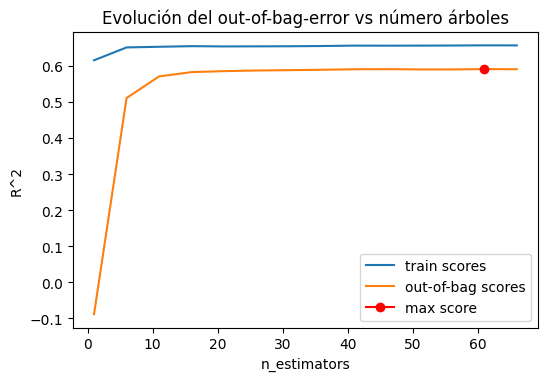

In [ ]:
# Validación empleando el Out-of-Bag error :

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 70, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = None,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_train, y_train)
    train_scores.append(modelRF.score(X_train, y_train))
    oob_scores.append(modelRF.oob_score_)



# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Ambos métodos indican que a partir de 20 arboles podemos tener un valor de evaluación estable

Valor óptimo de max_features: 44


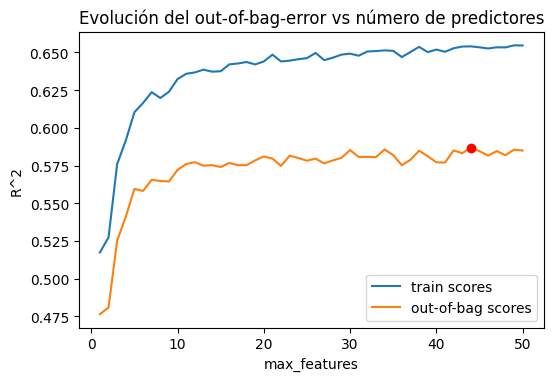

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_train, y_train)
    train_scores.append(modelRF.score(X_train, y_train))
    oob_scores.append(modelRF.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

In [ ]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor
modelRF = RandomForestRegressor(random_state = 123)

CV = 3

parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [25, 30, 35],
                'max_depth'   : [3, 5, 10]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'neg_root_mean_squared_error',         #'neg_root_mean_squared_error', 'r2'
                    n_jobs     = - 1,
                    cv         = CV,
                    refit      = True,
                    verbose    = 1,
                    return_train_score = True
                   )

grid_RF.fit(X = X_train, y = y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10], 'max_features': [25, 30, 35],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [ ]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_max_depth  param_max_features  param_n_estimators  mean_test_score  \
10                5                  25                  20        -0.052208   
11                5                  25                  25        -0.052237   
9                 5                  25                  15        -0.052375   
17                5                  35                  25        -0.052465   

    std_test_score  mean_train_score  std_train_score  
10        0.004368         -0.046037         0.001557  
11        0.004461         -0.045979         0.001604  
9         0.004503         -0.046211         0.001510  
17        0.004370         -0.045414         0.001441

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 5, 'max_features': 25, 'n_estimators': 20}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelRF = RandomForestRegressor( max_depth = best_params["max_depth"]
                               , max_features = best_params["max_features"]
                               , n_estimators = best_params["n_estimators"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=25, n_estimators=20,
                      random_state=1234)

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor   importancia
0                                     ROLLING_MEAN_1D  5.258366e-01
9                                      ROLLING_MAX_3D  1.689940e-01
4                                            SLOPE_7D  7.097601e-02
1                                     ROLLING_MEAN_3D  7.083557e-02
3                                            SLOPE_3D  5.954484e-02
7                                      ROLLING_MIN_3D  2.251241e-02
2                                     ROLLING_MEAN_7D  2.231980e-02
10                                     ROLLING_MAX_7D  1.229081e-02
12                                    ROLLING_SKEW_7D  9.546082e-03
5                                      ROLLING_STD_3D  8.521244e-03
6                                      ROLLING_STD_7D  5.738582e-03
11                                    ROLLING_SKEW_3D  4.560016e-03
8                                      ROLLING_MIN_7D  3.755266e-03
37                       subcategory_Dulces y postres  2.901385e-03
21  Quinta medida correctiva al Código Nacional de...  2.028574e-03
25  Tasa de homicidios en accidentes de tránsito p...  1.303608e-03
18  Primera medida correctiva al Código Nacional d...  1.124599e-03
15                   Fallecidos por siniestros viales  9.832237e-04
26  Tasa de hurto a personas por cada 100.000 habi...  7.435887e-04
19  Proporción en que son impuestas otras medidas ...  7.363224e-04
16                    Porcentaje población de hombres  6.739341e-04
30           Índice de Interrelación de Problemáticas  6.618103e-04
13                                ROLLING_KURTOSIS_3D  6.153438e-04
39                     subcategory_Limpieza de cocina  5.676870e-04
20                Puntaje SISBEN: Promedio - Cabecera  5.583434e-04
36                               subcategory_Despensa  5.345908e-04
38                      subcategory_Frutas y Verduras  4.001839e-04
23      Tasa de extorsión por cada 100.000 habitantes  2.065202e-04
22  Tasa de exámenes médico legales por presunto d...  1.848839e-04
42                              subcategory_Pasabocas  1.792905e-04
14  Cuarta medida correctiva al Código Nacional de...  1.057263e-04
27  Tasa de lesiones en accidentes de tránsito por...  5.842211e-05
29  Tasa de violencia intrafamiliar por cada 100.0...  6.947449e-07
17                    Porcentaje población de mujeres  0.000000e+00
33                            subcategory_Charcutería  0.000000e+00
32                                subcategory_Belleza  0.000000e+00
31                                subcategory_Bebidas  0.000000e+00
28      Tasa de secuestro por cada 100.000 habitantes  0.000000e+00
24  Tasa de homicidio intencional en hombres por c...  0.000000e+00
34                       subcategory_Cuidado Personal  0.000000e+00
40         subcategory_Lácteos, huevos y refrigerados  0.000000e+00
35              subcategory_Cuidado de ropa y calzado  0.000000e+00
41                 subcategory_Panadería y Pastelería  0.000000e+00
43                   subcategory_Productos Congelados  0.000000e+00
44                       subcategory_Utiles Escolares  0.000000e+00
45                        subcategory_Vinos y Licores  0.000000e+00
46                                        Dpto_CALDAS  0.000000e+00
47                                       Dpto_QUINDÍO  0.000000e+00
48                                     Dpto_RISARALDA  0.000000e+00
49                               Dpto_VALLE DEL CAUCA  0.000000e+00

In [ ]:
#los peores predictores
importancia_predictores.sort_values('importancia', ascending=False).tail(10)

predictor  importancia
40  subcategory_Lácteos, huevos y refrigerados          0.0
35       subcategory_Cuidado de ropa y calzado          0.0
41          subcategory_Panadería y Pastelería          0.0
43            subcategory_Productos Congelados          0.0
44                subcategory_Utiles Escolares          0.0
45                 subcategory_Vinos y Licores          0.0
46                                 Dpto_CALDAS          0.0
47                                Dpto_QUINDÍO          0.0
48                              Dpto_RISARALDA          0.0
49                        Dpto_VALLE DEL CAUCA          0.0

In [ ]:
importancia_predictores[importancia_predictores['importancia'] == 0]

predictor  importancia
17                    Porcentaje población de mujeres          0.0
24  Tasa de homicidio intencional en hombres por c...          0.0
28      Tasa de secuestro por cada 100.000 habitantes          0.0
31                                subcategory_Bebidas          0.0
32                                subcategory_Belleza          0.0
33                            subcategory_Charcutería          0.0
34                       subcategory_Cuidado Personal          0.0
35              subcategory_Cuidado de ropa y calzado          0.0
40         subcategory_Lácteos, huevos y refrigerados          0.0
41                 subcategory_Panadería y Pastelería          0.0
43                   subcategory_Productos Congelados          0.0
44                       subcategory_Utiles Escolares          0.0
45                        subcategory_Vinos y Licores          0.0
46                                        Dpto_CALDAS          0.0
47                                       Dpto_QUINDÍO          0.0
48                                     Dpto_RISARALDA          0.0
49                               Dpto_VALLE DEL CAUCA          0.0

In [ ]:
#los mejores predictores
importancia_predictores.sort_values('importancia', ascending=False).head(10)

predictor  importancia
0   ROLLING_MEAN_1D     0.525837
9    ROLLING_MAX_3D     0.168994
4          SLOPE_7D     0.070976
1   ROLLING_MEAN_3D     0.070836
3          SLOPE_3D     0.059545
7    ROLLING_MIN_3D     0.022512
2   ROLLING_MEAN_7D     0.022320
10   ROLLING_MAX_7D     0.012291
12  ROLLING_SKEW_7D     0.009546
5    ROLLING_STD_3D     0.008521

In [ ]:
importancia_predictores.importancia.sum()

np.float64(1.0)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelRF.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 20.27601902188819
El error (r2) de train es: 0.6416087705497917
El MAPE de train es: 0.5985888176668835


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelRF.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 17.582151470863828
El error (r2) de test es: 0.6249026431092214
El MAPE de test es: 0.4362920933885461


In [ ]:
evaluar_modelo('Random Forest', modelRF, X_train, y_train, X_test, y_test)

### XGBoost

In [ ]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor. Tarda 5 minutos

# Definir el modelo GradientBoosting
modelGrdB = GradientBoostingRegressor()

CV = 3

# Definir los parámetros a ajustar y sus posibles valores
parameters = {
    'n_estimators': [10, 25, 50, 75],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

grid_GrdB = GridSearchCV(
        estimator  = modelGrdB,
        param_grid = parameters,
        n_jobs     = - 1,
        cv         = CV,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GrdB.fit(X = X_train, y = y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 25, 50, 75]},
             return_train_score=True)

In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_GrdB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_learning_rate  param_max_depth  param_n_estimators  mean_test_score  \
5                  0.1                5                  25         0.544413   
1                  0.1                3                  25         0.543843   
3                  0.1                3                  75         0.534908   
2                  0.1                3                  50         0.533531   

   std_test_score  mean_train_score  std_train_score  
5        0.010195          0.745799         0.009828  
1        0.009312          0.630394         0.012977  
3        0.019793          0.703278         0.012236  
2        0.023512          0.678861         0.013032

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_GrdB.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelGrdB = GradientBoostingRegressor(
                                        learning_rate = best_params["learning_rate"]
                                       , max_depth = best_params["max_depth"]
                                       , n_estimators = best_params["n_estimators"]
                                       , random_state = 1234)


#Se entrena el modelo con los datos completos
modelGrdB.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=25, random_state=1234)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelGrdB.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 18.02147938432568
El error (r2) de train es: 0.7168784861339156
El MAPE de train es: 0.6035093016181047


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelGrdB.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 16.963420504854742
El error (r2) de test es: 0.6508381182811371
El MAPE de test es: 0.4583030881891185


In [ ]:
evaluar_modelo('Gradient Boosting', modelGrdB, X_train, y_train, X_test, y_test)

## 2.5. Modelos de Deep Learning

In [ ]:
#Evaluación del modelo
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#optimizar modelos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Modelos DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # Capa de salida para regresión

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# Realizar predicciones
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('Red Neuronal Básica', model, X_train, y_train, X_test, y_test) # Asegúrate de que evaluar_modelo funcione con modelos de Keras si es necesario


Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0129 - mae: 0.0686 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0058 - mae: 0.0443 - val_loss: 0.0031 - val_mae: 0.0326
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0049 - mae: 0.0408 - val_loss: 0.0033 - val_mae: 0.0300
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0031 - val_mae: 0.0294
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0027 - val_mae: 0.0280
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0040 - mae: 0.0359 - val_loss: 0.0029 - val_mae: 0.0283
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0045 - mae: 0.0356 - val_loss: 0.0027 - val_mae: 0.0274
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0028 - val_mae: 0.0273
Epoch 9/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

In [ ]:
##modelo 2
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(32, return_sequences=False))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='linear'))  # Capa de salida

# Compilar el modelo
optimizer = RMSprop(learning_rate=0.001)
model2.compile(loss='mse', optimizer=optimizer, metrics=['mae'])


# Entrenar el modelo con Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True,  # Recupera los mejores pesos alcanzados
    verbose=1
)
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[early_stopping])

# Realizar predicciones
y_pred = model2.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('LSTM Básica', model2, X_train, y_train, X_test, y_test) # Asegúrate de que evaluar_modelo funcione con modelos de Keras si es necesario


Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0061 - mae: 0.0461 - val_loss: 0.0042 - val_mae: 0.0346
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - loss: 0.0060 - mae: 0.0448 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 0.0060 - mae: 0.0441 - val_loss: 0.0040 - val_mae: 0.0371
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 0.0054 - mae: 0.0428 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0054 - mae: 0.0420 - val_loss: 0.0039 - val_mae: 0.0363
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 0.0055 - mae: 0.0423 - val_loss: 0.0039 - val_mae: 0.0399
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - loss: 0.0052 - mae: 0.0417 - val_loss: 0.0061 - val_mae: 0.0631
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0053 - mae: 0.0411 - val_loss: 0.0030 - val_mae: 0.0299
Epoch 9/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
pip install scikeras

In [ ]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop

# Define the Keras model architecture within a function
def build_keras_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create the KerasRegressor, passing the build function and the input shape
keras_model = KerasRegressor(model=build_keras_model, input_shape=X_train.shape[1],
                             epochs=50, batch_size=32
                             )

# Fit and score the estimator
keras_model.fit(X_train, y_train, validation_data=(X_test, y_test))

# Realizar keras_model
y_pred = keras_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('Keras Regresor Básico', keras_model, X_train, y_train, X_test, y_test)


Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0111 - mae: 0.0619 - val_loss: 0.0045 - val_mae: 0.0378
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0065 - mae: 0.0466 - val_loss: 0.0045 - val_mae: 0.0358
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0054 - mae: 0.0425 - val_loss: 0.0038 - val_mae: 0.0336
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0052 - mae: 0.0406 - val_loss: 0.0034 - val_mae: 0.0318
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0048 - mae: 0.0395 - val_loss: 0.0031 - val_mae: 0.0298
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0037 - val_mae: 0.0311
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0046 - mae: 0.0371 - val_loss: 0.0033 - val_mae: 0.0294
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0047 - mae: 0.0372 - val_loss: 0.0028 - val_mae: 0.0280
Epoch 9/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

## 2.6. Resumen resultados

In [ ]:
# Exportar DataFrame a CSV
df_metricas.to_csv('metricas_modelos_con_interpolacion.csv', index=False)

df_metricas

Modelo  RMSE_train  R2_train  MAPE_train  RMSE_test  \
0                   SVMR   21.331137  0.603339    0.519084  18.234909   
1        modelElasticNet   33.869127  0.000000    1.897586  28.723519   
2          Random Forest   20.276019  0.641609    0.598589  17.582151   
3      Gradient Boosting   18.021479  0.716878    0.603509  16.963421   
4    Red Neuronal Básica   23.234968  0.529374    0.825407  20.389902   
5            LSTM Básica   23.866371  0.503448    0.940550  19.313517   
6  Keras Regresor Básico   23.996054  0.498037    0.894042  20.307036   

    R2_test  MAPE_test  
0  0.596534   0.398089  
1 -0.001095   1.476399  
2  0.624903   0.436292  
3  0.650838   0.458303  
4  0.495536   0.625503  
5  0.547392   0.672313  
6  0.499628   0.668290

## 2.7. Predicciones datos de prueba

In [ ]:
## Generar columnas Dummy
dp_pruebas_rellenado = pd.get_dummies(dp_pruebas_rellenado, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in dp_pruebas_rellenado.select_dtypes(include='bool').columns:
    dp_pruebas_rellenado[col] = dp_pruebas_rellenado[col].astype(int)

In [ ]:
df_modelo.shape, dp_pruebas_rellenado.shape

((17847, 52), (2089, 52))

In [ ]:
##columnas que estan en dp_pruebas_rellenado y no en df_modelo
dp_pruebas_rellenado.columns.difference(df_modelo.columns)

Index([], dtype='object')

In [ ]:
X_prueba = dp_pruebas_rellenado.drop(columns = ["CANTIDAD", 'FECHA'])
y_prueba = dp_pruebas_rellenado['CANTIDAD']

In [ ]:
scaler #usamos el mismo scaler usado en entrenamiento

MinMaxScaler()

In [ ]:
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_prueba[num_vars] = scaler.transform(X_prueba[num_vars])
X_prueba[num_vars] = X_prueba[num_vars].fillna(0)
X_prueba[num_vars].sample(2)

ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  \
21121         0.004664         0.005627         0.007829  0.427830  0.405067   
20436         0.008772         0.006353         0.012907  0.433234  0.402966   

       ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D  \
21121        0.000676        0.001465        0.007430        0.010309   
20436        0.007570        0.007859        0.001825        0.003436   

       ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados  \
21121        0.004664  ...                                         0.0   
20436        0.008772  ...                                         0.0   

       subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
21121                                 0.0                    1.0   
20436                                 0.0                    0.0   

       subcategory_Productos Congelados  subcategory_Utiles Escolares  \
21121                               0.0                           0.0   
20436                               0.0                           0.0   

       subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
21121                          0.0          0.0           1.0             0.0   
20436                          0.0          0.0           0.0             1.0   

       Dpto_VALLE DEL CAUCA  
21121                   0.0  
20436                   0.0  

[2 rows x 50 columns]

In [ ]:
X_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2089 entries, 19115 to 21203
Data columns (total 50 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   ROLLING_MEAN_1D                                                                                        2089 non-null   float64
 1   ROLLING_MEAN_3D                                                                                        2089 non-null   float64
 2   ROLLING_MEAN_7D                                                                                        2089 non-null   float64
 3   SLOPE_3D                                                                                               2089 non-null   float64
 4   SLOPE_7D                                                                                        

In [ ]:
##predecir con los modelos entrenados
predicciones_svm = SVMR_Pol_opt.predict(X_prueba)
predicciones_elastic = modelElasticNet.predict(X_prueba)
predicciones_rf = modelRF.predict(X_prueba)
predicciones_gb = modelGrdB.predict(X_prueba)

predicciones_dl_basico = model.predict(X_prueba)
predicciones_lstm_basico = model2.predict(X_prueba)
predicciones_keras_basico = keras_model.predict(X_prueba)

#reescalar
predicciones_svm = scaler_y.inverse_transform(predicciones_svm.reshape(-1, 1))
predicciones_elastic = scaler_y.inverse_transform(predicciones_elastic.reshape(-1, 1))
predicciones_rf = scaler_y.inverse_transform(predicciones_rf.reshape(-1, 1))
predicciones_gb = scaler_y.inverse_transform(predicciones_gb.reshape(-1, 1))

predicciones_dl_basico = scaler_y.inverse_transform(predicciones_dl_basico)
predicciones_lstm_basico = scaler_y.inverse_transform(predicciones_lstm_basico)
predicciones_keras_basico = scaler_y.inverse_transform(predicciones_keras_basico)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
dp_pruebas_rellenado_original = pd.read_csv('df_pruebas_rellenado.csv')
dp_pruebas_rellenado_original.set_index(y_prueba.index, inplace=True)

In [ ]:
##crear dataframe con y_prueba, predicciones de cada modelo
df_predicciones = pd.DataFrame({'FECHA': dp_pruebas_rellenado_original['FECHA'],
                                'Dpto': dp_pruebas_rellenado_original['Dpto'],
                                'subcategory': dp_pruebas_rellenado_original['subcategory'],
                                'y_prueba': y_prueba,
                                # 'y_prueba_revision': dp_pruebas_rellenado_original['CANTIDAD'],
                                'predicciones_svr':predicciones_svm.flatten(), # Flatten the array
                                'predicciones_elastic':predicciones_elastic.flatten(), # Flatten the array
                                'predicciones_rf':predicciones_rf.flatten(), # Flatten the array
                                'predicciones_gb':predicciones_gb.flatten(), # Flatten the array

                                'predicciones_dl_basico':predicciones_dl_basico.flatten(), # Flatten the array
                                'predicciones_lstm':predicciones_lstm_basico.flatten(), # Flatten the array
                                'predicciones_kerasR':predicciones_keras_basico.flatten()}) # Flatten the array
df_predicciones.sample(10)

FECHA             Dpto                     subcategory   y_prueba  \
20781  2022-09-25  VALLE DEL CAUCA          Panadería y Pastelería   3.806452   
20530  2022-09-22           CALDAS  Lácteos, huevos y refrigerados   5.090909   
19679  2022-09-11  VALLE DEL CAUCA                 Vinos y Licores  13.692308   
21060  2022-09-29        ANTIOQUIA                Utiles Escolares  29.000000   
19772  2022-09-12        RISARALDA  Lácteos, huevos y refrigerados   3.937500   
20335  2022-09-19  VALLE DEL CAUCA                Dulces y postres  13.000000   
20970  2022-09-27           CALDAS                        Despensa   2.380952   
20122  2022-09-16  VALLE DEL CAUCA                 Vinos y Licores  17.923077   
19280  2022-09-06        ANTIOQUIA  Lácteos, huevos y refrigerados  41.333333   
20524  2022-09-22          QUINDÍO                     Charcutería   6.000000   

       predicciones_svr  predicciones_elastic  predicciones_rf  \
20781          7.433407             24.704176         4.805780   
20530          7.156030             24.704176         7.281619   
19679         19.385773             24.704176        15.803935   
21060         26.268366             24.704176        28.470467   
19772          1.967681             24.704176         5.051726   
20335         18.090909             24.704176        20.766614   
20970          5.985312             24.704176         5.331258   
20122         17.803466             24.704176        17.712315   
19280         38.751527             24.704176        38.807931   
20524          9.315344             24.704176         5.436190   

       predicciones_gb  predicciones_dl_basico  predicciones_lstm  \
20781         7.058010                9.199243          11.746133   
20530         6.911362               10.884830           8.351487   
19679        14.533220               17.290283          21.325985   
21060        27.812048               28.637812          31.217884   
19772         6.026571                9.199243           7.248363   
20335        21.469013               24.859110          31.242794   
20970         5.976902               11.681987           7.867423   
20122        18.012909               18.966433          18.339655   
19280        41.568410               32.595135          34.169842   
20524         7.073059                9.199243          16.606958   

       predicciones_kerasR  
20781            11.627813  
20530            11.627813  
19679            12.092463  
21060            24.528814  
19772            11.627813  
20335            20.216770  
20970            11.627813  
20122            14.519920  
19280            32.427071  
20524            11.627813

In [ ]:
# prompt: Calcule el RMSE, R2 y MAPE de las predicciones para cada subregion y cada subcategoria

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Crear un DataFrame vacío para almacenar métricas por subregión y subcategoría
df_metricas_detalle = pd.DataFrame(columns=['Dpto', 'subcategory',
                                            'Modelo', 'RMSE', 'R2', 'MAPE'])

# Iterar sobre cada subregión única
for subregion in df_predicciones['Dpto'].unique():
    # Iterar sobre cada subcategoría única dentro de la subregión
    for subcategory in df_predicciones[df_predicciones['Dpto'] == subregion]['subcategory'].unique():
        # Filtrar el DataFrame para la subregión y subcategoría actuales
        df_subset = df_predicciones[(df_predicciones['Dpto'] == subregion) &
                                    (df_predicciones['subcategory'] == subcategory)].copy()

        if len(df_subset) > 1: # Ensure there are enough samples to calculate metrics
            y_true_subset = df_subset['y_prueba']

            # Calculate metrics for each model
            models = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
                'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR']
            model_names = ['SVR', 'ElasticNet', 'Random Forest', 'Gradient Boosting',
                'Red Neuronal Básica', 'LSTM Básica', 'Keras Regresor Básico']

            for model_col, model_name in zip(models, model_names):
                y_pred_subset = df_subset[model_col]

                # Calculate metrics
                rmse = np.sqrt(metrics.mean_squared_error(y_true_subset, y_pred_subset))
                r2 = metrics.r2_score(y_true_subset, y_pred_subset)

                # Avoid division by zero in MAPE calculation for cases where actual values are zero
                if (y_true_subset == 0).any():
                    mape = np.nan # Or some other indicator, as MAPE is not well-defined when true values are zero
                else:
                    mape = mean_absolute_percentage_error(y_true_subset, y_pred_subset)


                # Agregar resultados al DataFrame
                df_metricas_detalle = pd.concat([df_metricas_detalle, pd.DataFrame({
                    'Dpto': [subregion],
                    'subcategory': [subcategory],
                    'Modelo': [model_name],
                    'RMSE': [rmse],
                    'R2': [r2],
                    'MAPE': [mape]
                })], ignore_index=True)

# Display the resulting DataFrame
print("Métricas por Subregión y Subcategoría:")
df_metricas_detalle


Métricas por Subregión y Subcategoría:


Dpto           subcategory                 Modelo       RMSE  \
0    ANTIOQUIA  Productos Congelados                    SVR   3.336533   
1    ANTIOQUIA  Productos Congelados             ElasticNet  17.319282   
2    ANTIOQUIA  Productos Congelados          Random Forest   2.119974   
3    ANTIOQUIA  Productos Congelados      Gradient Boosting   3.330829   
4    ANTIOQUIA  Productos Congelados    Red Neuronal Básica   6.850780   
..         ...                   ...                    ...        ...   
555  RISARALDA      Dulces y postres          Random Forest  23.503917   
556  RISARALDA      Dulces y postres      Gradient Boosting  24.819998   
557  RISARALDA      Dulces y postres    Red Neuronal Básica  19.826901   
558  RISARALDA      Dulces y postres            LSTM Básica  21.326597   
559  RISARALDA      Dulces y postres  Keras Regresor Básico  33.174450   

            R2        MAPE  
0    -2.336754   44.425160  
1   -88.906919  248.909265  
2    -0.347083   23.665571  
3    -2.325356   44.170336  
4   -13.067383   98.282306  
..         ...         ...  
555   0.779424   34.780290  
556   0.754031   28.888360  
557   0.843041   49.592089  
558   0.818398   55.191328  
559   0.560575   44.833341  

[560 rows x 6 columns]

In [ ]:
df_predicciones[['Dpto', 'subcategory']].value_counts()

Dpto       subcategory              
ANTIOQUIA  Aseo de hogar                27
           Bebidas                      27
           Belleza                      27
           Charcutería                  27
           Cuidado Personal             27
                                        ..
QUINDÍO    Cuidado Personal             26
RISARALDA  Utiles Escolares             14
CALDAS     Cuidado de ropa y calzado    13
QUINDÍO    Belleza                       6
           Cuidado de ropa y calzado     5
Name: count, Length: 80, dtype: int64

In [ ]:
df_predicciones[(df_predicciones['Dpto']=='ANTIOQUIA') & (df_predicciones['subcategory']=='Frutas y Verduras')]

FECHA       Dpto        subcategory  y_prueba  predicciones_svr  \
19143  2022-09-04  ANTIOQUIA  Frutas y Verduras     62.00         33.094313   
19253  2022-09-05  ANTIOQUIA  Frutas y Verduras    100.00         57.393847   
19335  2022-09-06  ANTIOQUIA  Frutas y Verduras    138.00         79.310833   
19412  2022-09-07  ANTIOQUIA  Frutas y Verduras    176.00        101.080673   
19447  2022-09-08  ANTIOQUIA  Frutas y Verduras     95.00        126.629194   
19534  2022-09-09  ANTIOQUIA  Frutas y Verduras     70.00         70.217812   
19594  2022-09-10  ANTIOQUIA  Frutas y Verduras     56.00         55.236686   
19726  2022-09-11  ANTIOQUIA  Frutas y Verduras     92.25         54.089584   
19803  2022-09-12  ANTIOQUIA  Frutas y Verduras    128.50         79.835714   
19881  2022-09-13  ANTIOQUIA  Frutas y Verduras    164.75        102.344524   
19983  2022-09-14  ANTIOQUIA  Frutas y Verduras    201.00        123.892796   
20050  2022-09-15  ANTIOQUIA  Frutas y Verduras    224.00        142.240181   
20110  2022-09-16  ANTIOQUIA  Frutas y Verduras     17.00        158.110239   
20185  2022-09-17  ANTIOQUIA  Frutas y Verduras    145.00         18.525922   
20217  2022-09-18  ANTIOQUIA  Frutas y Verduras     82.50        113.600079   
20350  2022-09-19  ANTIOQUIA  Frutas y Verduras     20.00         74.881716   
20375  2022-09-20  ANTIOQUIA  Frutas y Verduras     34.00         23.886064   
20505  2022-09-21  ANTIOQUIA  Frutas y Verduras     87.00         35.593466   
20523  2022-09-22  ANTIOQUIA  Frutas y Verduras     34.00         67.747892   
20655  2022-09-23  ANTIOQUIA  Frutas y Verduras     44.00         34.183497   
20715  2022-09-24  ANTIOQUIA  Frutas y Verduras      8.00         42.088133   
20811  2022-09-25  ANTIOQUIA  Frutas y Verduras      8.00         20.759905   
20842  2022-09-26  ANTIOQUIA  Frutas y Verduras      8.00         22.284927   
20933  2022-09-27  ANTIOQUIA  Frutas y Verduras      8.00         21.290587   
21002  2022-09-28  ANTIOQUIA  Frutas y Verduras      8.00         21.151281   
21127  2022-09-29  ANTIOQUIA  Frutas y Verduras     66.00         21.993045   
21179  2022-09-30  ANTIOQUIA  Frutas y Verduras     28.00         59.220421   

       predicciones_elastic  predicciones_rf  predicciones_gb  \
19143             24.704176        27.749736        34.647953   
19253             24.704176        60.451882        60.864382   
19335             24.704176        81.576276        84.970733   
19412             24.704176        97.988858        97.092380   
19447             24.704176       154.979902       164.791860   
19534             24.704176        79.338876        72.595280   
19594             24.704176        49.797566        39.206906   
19726             24.704176        50.164155        40.171616   
19803             24.704176        84.047193        86.089799   
19881             24.704176        99.105311        93.502575   
19983             24.704176       138.465063       148.846490   
20050             24.704176       151.757554       138.162083   
20110             24.704176       149.196686       142.700406   
20185             24.704176        26.658989        28.836215   
20217             24.704176        78.644344        55.438483   
20350             24.704176        63.619245        48.259014   
20375             24.704176        24.716903        30.213423   
20505             24.704176        33.014480        43.046790   
20523             24.704176        76.004092        73.973549   
20655             24.704176        33.240102        38.956018   
20715             24.704176        38.036920        35.268486   
20811             24.704176        21.695709        27.240319   
20842             24.704176        21.251148        25.934616   
20933             24.704176        12.768723        23.467099   
21002             24.704176        12.768723        22.775703   
21127             24.704176        11.980305        19.764471   
21179             24.704176        64.072912

In [ ]:
##las mejores predicciones
df_metricas_detalle.sort_values(by="RMSE", ascending=True).head(10)

Dpto                subcategory             Modelo      RMSE  \
383    QUINDÍO                    Belleza        LSTM Básica  0.262407   
548  RISARALDA     Panadería y Pastelería      Random Forest  0.608262   
546  RISARALDA     Panadería y Pastelería                SVR  0.609834   
129     CALDAS  Cuidado de ropa y calzado  Gradient Boosting  0.661652   
409    QUINDÍO              Aseo de hogar  Gradient Boosting  0.673003   
128     CALDAS  Cuidado de ropa y calzado      Random Forest  0.687614   
450  RISARALDA            Vinos y Licores      Random Forest  0.719127   
465  RISARALDA  Cuidado de ropa y calzado  Gradient Boosting  0.731044   
380    QUINDÍO                    Belleza      Random Forest  0.744507   
420    QUINDÍO     Panadería y Pastelería                SVR  0.822875   

           R2       MAPE  
383  0.919889   0.971845  
548  0.934160   5.697898  
546  0.933819   4.781659  
129  0.331109   4.285765  
409  0.941068   4.706005  
128  0.277589   4.896670  
450  0.675838   7.004618  
465  0.869491   2.823569  
380  0.355118   2.990604  
420 -1.064409  11.298112

In [ ]:
##las peores predicciones
df_metricas_detalle.sort_values(by="RMSE", ascending=True).tail(10)

Dpto         subcategory                 Modelo       RMSE  \
61         ANTIOQUIA    Dulces y postres            LSTM Básica  75.559437   
62         ANTIOQUIA    Dulces y postres  Keras Regresor Básico  78.762571   
58         ANTIOQUIA    Dulces y postres          Random Forest  80.147565   
60         ANTIOQUIA    Dulces y postres    Red Neuronal Básica  80.777216   
29         ANTIOQUIA   Frutas y Verduras             ElasticNet  82.087926   
267  VALLE DEL CAUCA  Limpieza de cocina             ElasticNet  86.862341   
190           CALDAS            Despensa             ElasticNet  86.949715   
59         ANTIOQUIA    Dulces y postres      Gradient Boosting  87.205288   
57         ANTIOQUIA    Dulces y postres             ElasticNet  93.532006   
56         ANTIOQUIA    Dulces y postres                    SVR  95.401345   

           R2        MAPE  
61   0.269557   63.618548  
62   0.206314   78.596840  
58   0.178156   43.946610  
60   0.165192   80.403948  
29  -0.726948   89.782654  
267 -0.926275   76.165815  
190 -0.188838  416.590513  
59   0.027041   61.600938  
57  -0.119256   43.088558  
56  -0.164442   37.634785

In [ ]:
df_predicciones['FECHA'] = pd.to_datetime(df_predicciones['FECHA'])

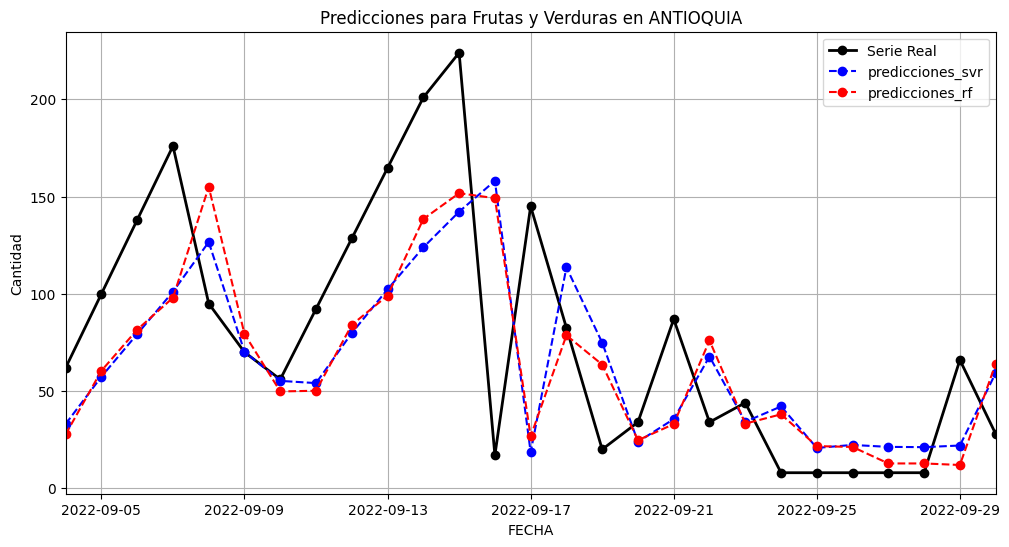

Métricas para Frutas y Verduras en ANTIOQUIA:
         Dpto        subcategory                 Modelo       RMSE        R2  \
28  ANTIOQUIA  Frutas y Verduras                    SVR  55.013554  0.224360   
29  ANTIOQUIA  Frutas y Verduras             ElasticNet  82.087926 -0.726948   
30  ANTIOQUIA  Frutas y Verduras          Random Forest  53.307253  0.271729   
31  ANTIOQUIA  Frutas y Verduras      Gradient Boosting  52.850409  0.284158   
32  ANTIOQUIA  Frutas y Verduras    Red Neuronal Básica  59.602366  0.089568   
33  ANTIOQUIA  Frutas y Verduras            LSTM Básica  53.057305  0.278542   
34  ANTIOQUIA  Frutas y Verduras  Keras Regresor Básico  59.924778  0.079691   

          MAPE  
28  115.330650  
29   89.782654  
30  104.168035  
31  111.551760  
32  120.423320  
33  136.789742  
34  118.544892  


In [ ]:
def plot_subregion_subcategory_predictions(df_predicciones, subregion_name, subcategory_name, modelos_a_graficar):
    """ Grafica la serie real y las predicciones de modelos específicos. """
    df_subset = df_predicciones[
        (df_predicciones['Dpto'] == subregion_name) &
        (df_predicciones['subcategory'] == subcategory_name)
    ].copy()

    if df_subset.empty:
        print(f"No hay datos para {subregion_name} - {subcategory_name}")
        return

    df_subset = df_subset.sort_values(by='FECHA')

    plt.figure(figsize=(12, 6))
    plt.plot(df_subset['FECHA'], df_subset['y_prueba'], label='Serie Real', marker='o', linewidth=2, color='black')

    colores = {
        'predicciones_svr': 'blue',
        'predicciones_elastic': 'green',
        'predicciones_rf': 'red',
        'predicciones_gb': 'purple',
        'predicciones_dl_basico': 'orange',
        'predicciones_lstm': 'brown',
        'predicciones_kerasR': 'pink'
    }

    for modelo in modelos_a_graficar:
        if modelo in df_subset.columns:
            plt.plot(df_subset['FECHA'], df_subset[modelo], label=modelo, marker='o', linestyle='dashed', color=colores.get(modelo, 'gray'))

    plt.xlabel('FECHA')
    plt.ylabel('Cantidad')
    plt.title(f'Predicciones para {subcategory_name} en {subregion_name}')
    plt.xlim(df_subset['FECHA'].min(), df_subset['FECHA'].max())
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Métricas para {subcategory_name} en {subregion_name}:")
    print(df_metricas_detalle[
        (df_metricas_detalle['Dpto'] == subregion_name) &
        (df_metricas_detalle['subcategory'] == subcategory_name)
    ])

# Selección de modelos específicos
modelos_seleccionados = ['predicciones_svr', 'predicciones_rf']
plot_subregion_subcategory_predictions(df_predicciones, 'ANTIOQUIA', 'Frutas y Verduras', modelos_seleccionados)

In [ ]:
df_metricas

Modelo  RMSE_train  R2_train  MAPE_train  RMSE_test  \
0                   SVMR   21.331137  0.603339    0.519084  18.234909   
1        modelElasticNet   33.869127  0.000000    1.897586  28.723519   
2          Random Forest   20.276019  0.641609    0.598589  17.582151   
3      Gradient Boosting   18.021479  0.716878    0.603509  16.963421   
4    Red Neuronal Básica   23.234968  0.529374    0.825407  20.389902   
5            LSTM Básica   23.866371  0.503448    0.940550  19.313517   
6  Keras Regresor Básico   23.996054  0.498037    0.894042  20.307036   

    R2_test  MAPE_test  
0  0.596534   0.398089  
1 -0.001095   1.476399  
2  0.624903   0.436292  
3  0.650838   0.458303  
4  0.495536   0.625503  
5  0.547392   0.672313  
6  0.499628   0.668290

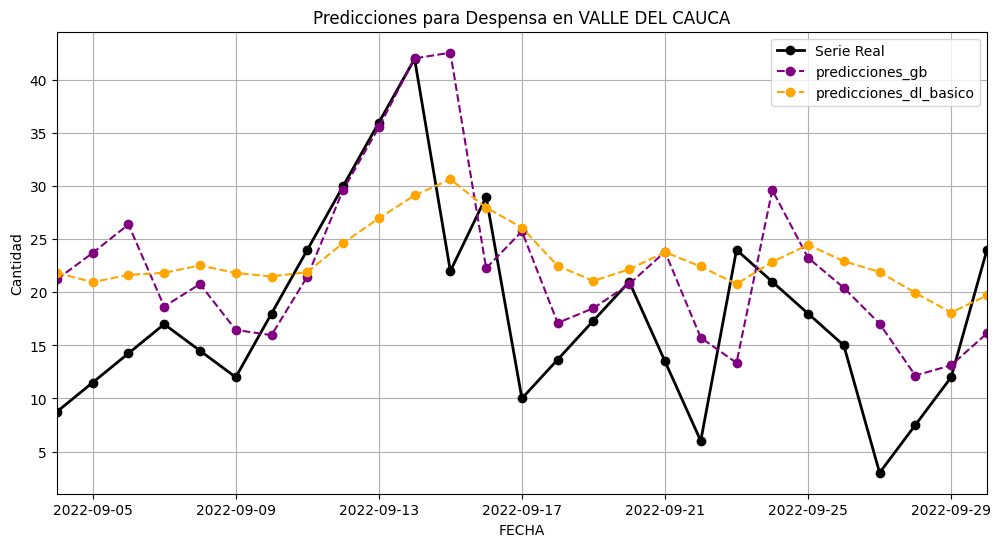

Métricas para Despensa en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo       RMSE        R2  \
308  VALLE DEL CAUCA    Despensa                    SVR   7.919644  0.203381   
309  VALLE DEL CAUCA    Despensa             ElasticNet  11.143503 -0.577186   
310  VALLE DEL CAUCA    Despensa          Random Forest   9.043432 -0.038737   
311  VALLE DEL CAUCA    Despensa      Gradient Boosting   8.572379  0.066655   
312  VALLE DEL CAUCA    Despensa    Red Neuronal Básica   9.197058 -0.074329   
313  VALLE DEL CAUCA    Despensa            LSTM Básica  13.028469 -1.155887   
314  VALLE DEL CAUCA    Despensa  Keras Regresor Básico   8.491110  0.084268   

          MAPE  
308  58.409468  
309  96.905346  
310  66.572870  
311  63.626944  
312  80.497594  
313  99.328837  
314  67.692352  


In [ ]:
# Selección de modelos específicos
modelos_seleccionados = ['predicciones_gb', 'predicciones_dl_basico']
plot_subregion_subcategory_predictions(df_predicciones, 'VALLE DEL CAUCA', 'Despensa', modelos_seleccionados)

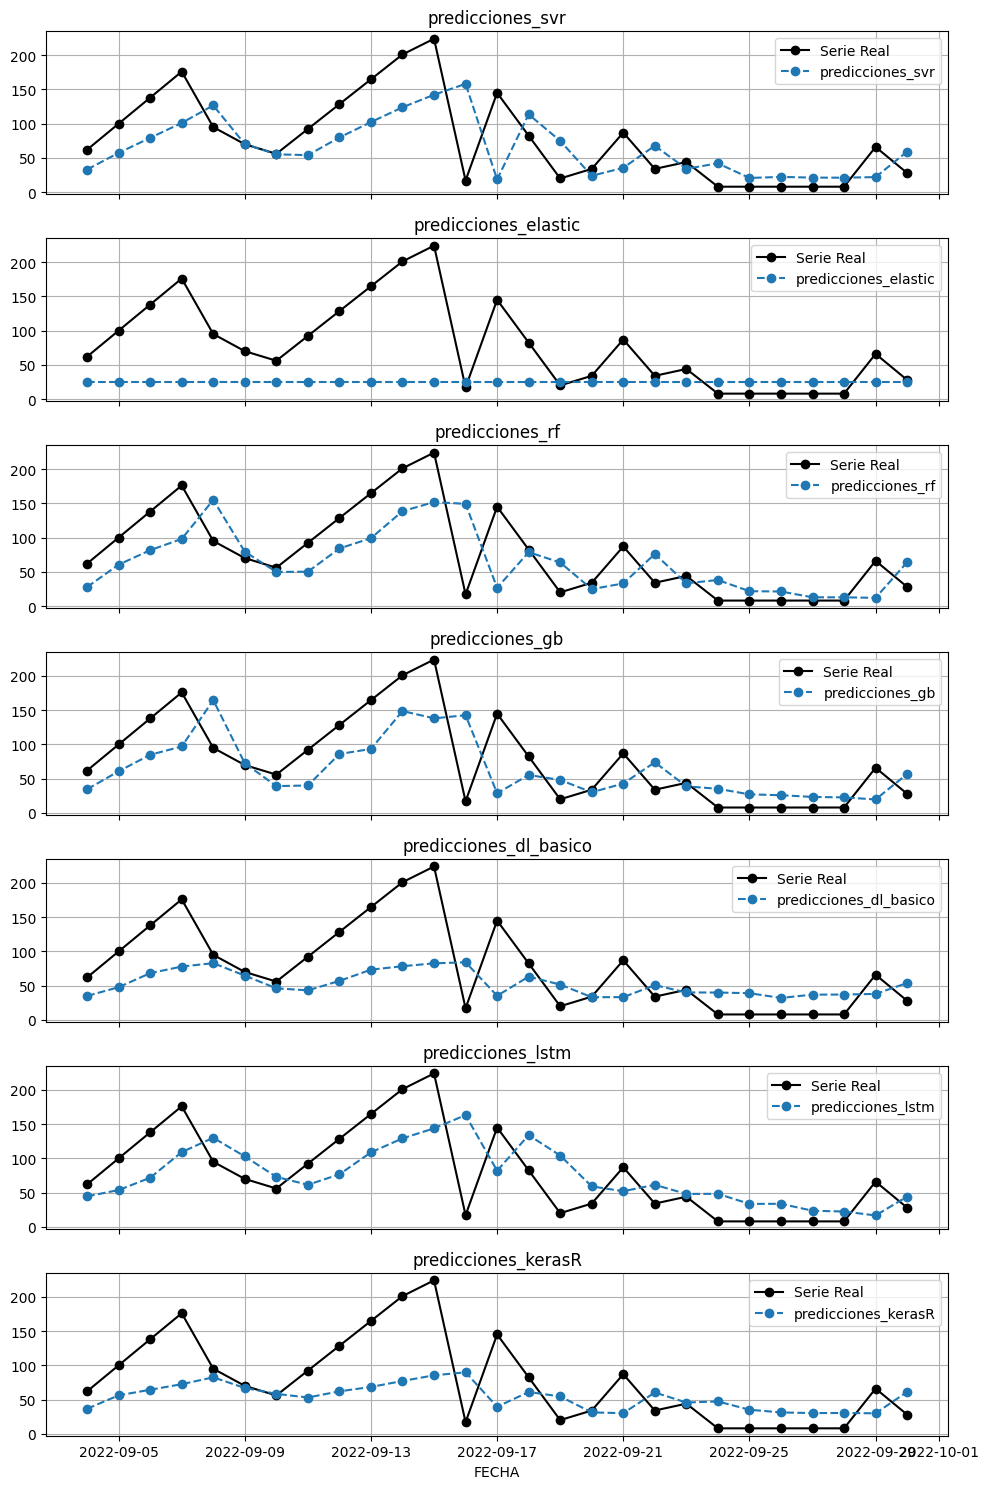

In [ ]:
def plot_subregion_subcategory_predictions_subplot(df_predicciones, subregion_name, subcategory_name):
    modelos = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
               'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR']

    df_subset = df_predicciones[
        (df_predicciones['Dpto'] == subregion_name) &
        (df_predicciones['subcategory'] == subcategory_name)
    ].copy()

    if df_subset.empty:
        print(f"No hay datos para {subregion_name} - {subcategory_name}")
        return

    df_subset = df_subset.sort_values(by='FECHA')

    fig, axes = plt.subplots(nrows=len(modelos), ncols=1, figsize=(10, 15), sharex=True)

    for i, modelo in enumerate(modelos):
        if modelo in df_subset.columns:
            axes[i].plot(df_subset['FECHA'], df_subset['y_prueba'], label='Serie Real', marker='o', color='black')
            axes[i].plot(df_subset['FECHA'], df_subset[modelo], label=modelo, marker='o', linestyle='dashed')
            axes[i].set_title(f'{modelo}')
            axes[i].legend()
            axes[i].grid(True)

    plt.xlabel('FECHA')
    plt.tight_layout()
    plt.show()

plot_subregion_subcategory_predictions_subplot(df_predicciones, 'ANTIOQUIA', 'Frutas y Verduras')

In [ ]:
# prompt: Represente graficamente el dataframe df_metricas_detalle, me interesa visualizar las subcategorias con mayor error, al igual que las subregiones

# Analizar las subcategorías con mayor error (usando RMSE como ejemplo)
df_rmse_subcategoria = df_metricas_detalle.groupby('subcategory')['RMSE'].mean().reset_index()
df_rmse_subcategoria = df_rmse_subcategoria.sort_values(by='RMSE', ascending=False)

print("\nSubcategorías con mayor RMSE promedio:")
print(df_rmse_subcategoria.head())

# Visualizar el RMSE promedio por subcategoría
fig_subcat_rmse = px.bar(df_rmse_subcategoria, x='subcategory', y='RMSE',
                         title='RMSE promedio por Subcategoría',
                         labels={'subcategory': 'Subcategoría', 'RMSE': 'RMSE Promedio'})
fig_subcat_rmse.update_xaxes(tickangle=90)
fig_subcat_rmse.show()


# Analizar las subregiones con mayor error (usando RMSE como ejemplo)
df_rmse_subregion = df_metricas_detalle.groupby('Dpto')['RMSE'].mean().reset_index()
df_rmse_subregion = df_rmse_subregion.sort_values(by='RMSE', ascending=False)

print("\nSubregiones con mayor RMSE promedio:")
print(df_rmse_subregion.head())

# Visualizar el RMSE promedio por subregión
fig_subregion_mape = px.bar(df_rmse_subregion, x='Dpto', y='RMSE',
                            title='RMSE promedio por Subregión',
                            labels={'Dpto': 'Subregión', 'RMSE': 'RMSE Promedio'})
fig_subregion_mape.update_xaxes(tickangle=90)
fig_subregion_mape.show()


Subcategorías con mayor RMSE promedio:
           subcategory       RMSE
7     Dulces y postres  36.230819
8    Frutas y Verduras  26.593703
12           Pasabocas  21.617779
6             Despensa  19.091402
9   Limpieza de cocina  15.919242



Subregiones con mayor RMSE promedio:
              Dpto       RMSE
0        ANTIOQUIA  23.057661
4  VALLE DEL CAUCA  18.033324
1           CALDAS   9.260050
3        RISARALDA   7.943572
2          QUINDÍO   5.956934


In [ ]:
# Crear un DataFrame para graficar las métricas por modelo en el conjunto de prueba
df_metricas_plot = df_metricas[['Modelo', 'RMSE_test', 'MAPE_test']].copy()

# Derretir el DataFrame para tener las métricas en filas (para Plotly Express)
df_melted = df_metricas_plot.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# Mapear nombres de métricas para mejor visualización
df_melted['Métrica'] = df_melted['Métrica'].replace({
    'RMSE_test': 'RMSE',
    'MAPE_test': 'MAPE'
})

# Crear el gráfico de barras agrupado
fig = px.bar(df_melted, x='Modelo', y='Valor', color='Métrica', barmode='group',
             title='RMSE y MAPE por Modelo (Conjunto de Prueba)',
             labels={'Modelo': 'Modelo', 'Valor': 'Valor de Métrica', 'Métrica': 'Métrica'},
             color_discrete_sequence=px.colors.qualitative.Vivid) # Cambiar la paleta de colores

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title='Modelo',
    yaxis_title='Valor de Métrica',
    title_font_size=16,
    legend_title='Métrica',
    template='plotly_white' # Usar un template diferente para un aspecto más limpio
)

# Mostrar el gráfico
fig.show()


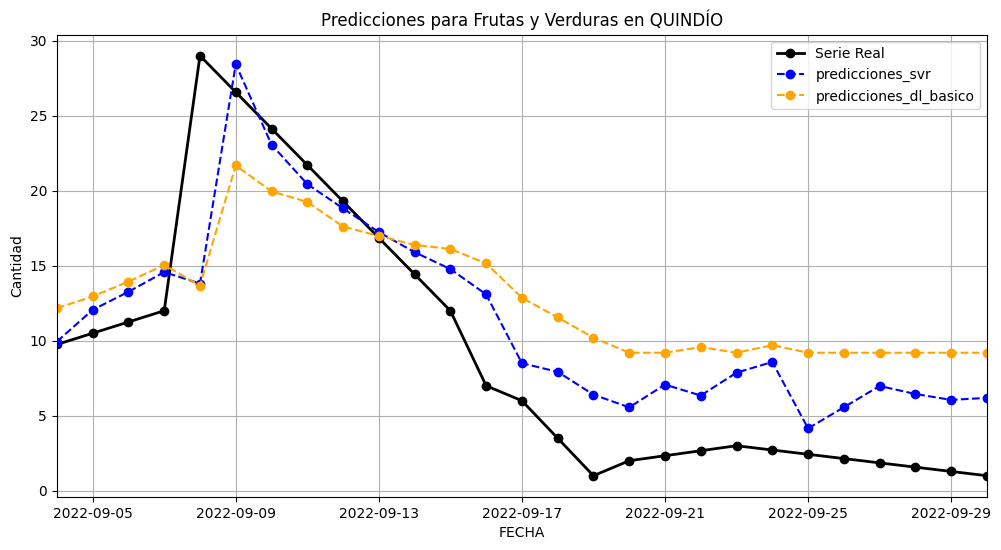

Métricas para Frutas y Verduras en QUINDÍO:
        Dpto        subcategory                 Modelo       RMSE        R2  \
371  QUINDÍO  Frutas y Verduras                    SVR   4.610242  0.706896   
372  QUINDÍO  Frutas y Verduras             ElasticNet  17.701802 -3.321244   
373  QUINDÍO  Frutas y Verduras          Random Forest   5.246804  0.620367   
374  QUINDÍO  Frutas y Verduras      Gradient Boosting   6.888927  0.345549   
375  QUINDÍO  Frutas y Verduras    Red Neuronal Básica   6.580494  0.402840   
376  QUINDÍO  Frutas y Verduras            LSTM Básica   7.332543  0.258548   
377  QUINDÍO  Frutas y Verduras  Keras Regresor Básico   7.695893  0.183245   

           MAPE  
371  132.015094  
372  654.182668  
373  124.035832  
374  241.012944  
375  219.929638  
376  212.228329  
377  271.243149  


In [ ]:
# Llama a la función con la subregión y subcategoría deseadas
plot_subregion_subcategory_predictions(df_predicciones, 'QUINDÍO', 'Frutas y Verduras', modelos_a_graficar = ['predicciones_svr',
                                                                                                              'predicciones_dl_basico'])

In [ ]:
df_modelo.shape

(17847, 52)

In [ ]:
#drop if exists of before predictions
cols_to_drop = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
                'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR', 'y_prueba']

for col in cols_to_drop:
  if col in df_interpolado.columns:
    df_interpolado = df_interpolado.drop(columns=[col])


##predicciones al dataset completo df_interpolado
X = df_interpolado.drop(columns = ["CANTIDAD", 'FECHA'])
y = df_interpolado['CANTIDAD']

#dummies
X = pd.get_dummies(X, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

##escalar
X[num_vars] = scaler.transform(X[num_vars])
X[num_vars] = X[num_vars].fillna(0)

df_interpolado['predicciones_svr'] = scaler_y.inverse_transform(SVMR_Pol_opt.predict(X).reshape(-1, 1))
df_interpolado['predicciones_elastic'] = scaler_y.inverse_transform(modelElasticNet.predict(X).reshape(-1, 1))
df_interpolado['predicciones_rf'] = scaler_y.inverse_transform(modelRF.predict(X).reshape(-1, 1))
df_interpolado['predicciones_gb'] = scaler_y.inverse_transform(modelGrdB.predict(X).reshape(-1, 1))
df_interpolado['predicciones_dl_basico'] = scaler_y.inverse_transform(model.predict(X).reshape(-1, 1))
df_interpolado['predicciones_lstm'] = scaler_y.inverse_transform(model2.predict(X))
df_interpolado['predicciones_kerasR'] = scaler_y.inverse_transform(keras_model.predict(X))
df_interpolado['y_prueba'] = y


663/663 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


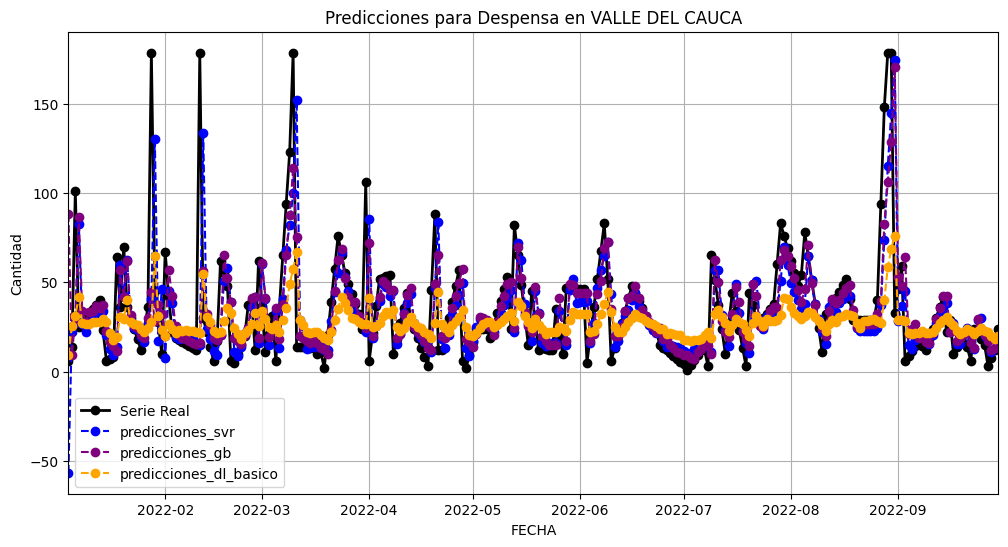

Métricas para Despensa en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo       RMSE        R2  \
308  VALLE DEL CAUCA    Despensa                    SVR   7.919644  0.203381   
309  VALLE DEL CAUCA    Despensa             ElasticNet  11.143503 -0.577186   
310  VALLE DEL CAUCA    Despensa          Random Forest   9.043432 -0.038737   
311  VALLE DEL CAUCA    Despensa      Gradient Boosting   8.572379  0.066655   
312  VALLE DEL CAUCA    Despensa    Red Neuronal Básica   9.197058 -0.074329   
313  VALLE DEL CAUCA    Despensa            LSTM Básica  13.028469 -1.155887   
314  VALLE DEL CAUCA    Despensa  Keras Regresor Básico   8.491110  0.084268   

          MAPE  
308  58.409468  
309  96.905346  
310  66.572870  
311  63.626944  
312  80.497594  
313  99.328837  
314  67.692352  


In [ ]:
##visualizar una serie con la funcion construida
cat = "Despensa"
region = "VALLE DEL CAUCA"

plot_subregion_subcategory_predictions(df_interpolado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

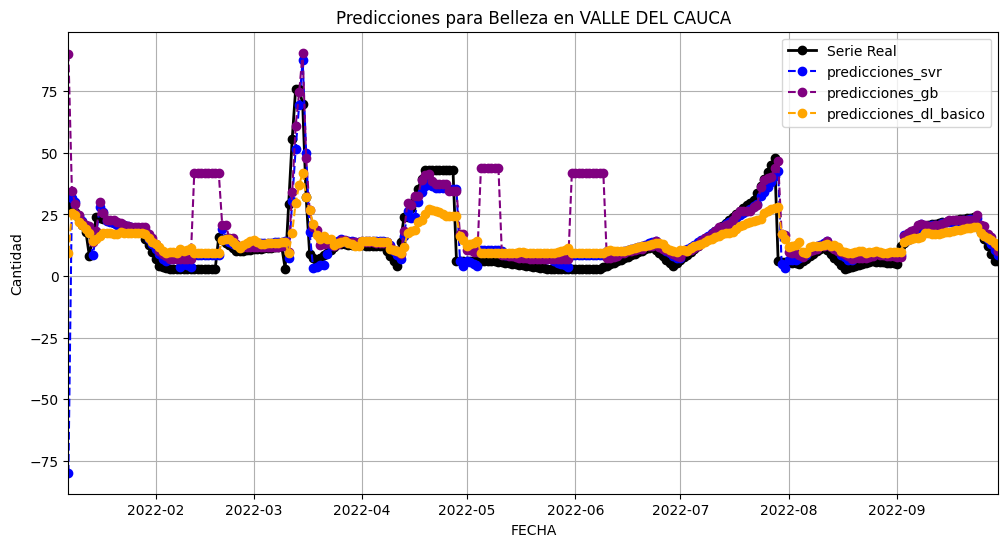

Métricas para Belleza en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo      RMSE        R2  \
329  VALLE DEL CAUCA     Belleza                    SVR  1.624646  0.898722   
330  VALLE DEL CAUCA     Belleza             ElasticNet  7.696716 -1.273051   
331  VALLE DEL CAUCA     Belleza          Random Forest  2.558495  0.748830   
332  VALLE DEL CAUCA     Belleza      Gradient Boosting  2.734587  0.713066   
333  VALLE DEL CAUCA     Belleza    Red Neuronal Básica  4.025557  0.378201   
334  VALLE DEL CAUCA     Belleza            LSTM Básica  3.635169  0.492954   
335  VALLE DEL CAUCA     Belleza  Keras Regresor Básico  7.671014 -1.257895   

          MAPE  
329   9.932653  
330  50.959937  
331  14.478834  
332  16.267106  
333  25.037872  
334  21.737098  
335  40.005019  


In [ ]:
##visualizar una serie con la funcion construida
cat = "Belleza"
region = "VALLE DEL CAUCA"

plot_subregion_subcategory_predictions(df_interpolado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

In [ ]:
df_interpolado[(df_interpolado['Dpto']=='VALLE DEL CAUCA') & (df_interpolado['subcategory']=='Belleza')]["CANTIDAD"].max()

76.0

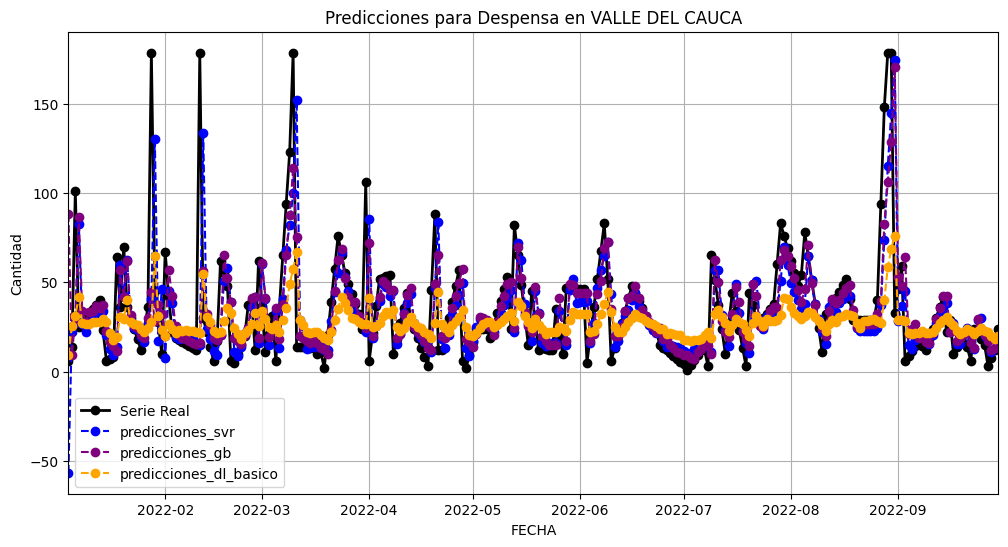

Métricas para Despensa en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo       RMSE        R2  \
308  VALLE DEL CAUCA    Despensa                    SVR   7.919644  0.203381   
309  VALLE DEL CAUCA    Despensa             ElasticNet  11.143503 -0.577186   
310  VALLE DEL CAUCA    Despensa          Random Forest   9.043432 -0.038737   
311  VALLE DEL CAUCA    Despensa      Gradient Boosting   8.572379  0.066655   
312  VALLE DEL CAUCA    Despensa    Red Neuronal Básica   9.197058 -0.074329   
313  VALLE DEL CAUCA    Despensa            LSTM Básica  13.028469 -1.155887   
314  VALLE DEL CAUCA    Despensa  Keras Regresor Básico   8.491110  0.084268   

          MAPE  
308  58.409468  
309  96.905346  
310  66.572870  
311  63.626944  
312  80.497594  
313  99.328837  
314  67.692352  


In [ ]:
##visualizar una serie con la funcion construida
cat = "Despensa"
region = "VALLE DEL CAUCA"

plot_subregion_subcategory_predictions(df_interpolado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

# Referencias

- *scikit-learn:*   
    - https://scikit-learn.org/stable/

- *Tensorflow:*   
    - https://www.tensorflow.org/

- *Gráficas con  plotly:*
    - https://plotly.com/python/

- *Compras Dataset:*
    - https://www.kaggle.com/datasets/davidms8/shopping-map
    
- *Lista Productos Con categoria:*
    - https://www.kaggle.com/datasets/camiloemartinez/productos-consumo-masivo

